<a href="https://colab.research.google.com/github/abay-qkt/lightgbm-handbook/blob/main/LightGBM_handbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LightGBM Handbook

私がLightGBM使う上で調べたことをまとめてみました！  
基本的な使い方や注意事項、便利関数、自動パラメータチューニングについて書いています。

LightGBMについて基本的なことは知ってる人はチートシート的に見ていただけると思います！
基本的な機能だけでなく、LightGBMを使う上での注意点だったり、可視化の便利関数だったり普通に使っていても気づきづらいことも掲載しています。どれか一つでもお役に立てば幸いです！

In [ ]:
!pip install lightgbm==4.5.0

In [ ]:
!pip install optuna-integration

# 基本

## Python API
lightGBMに関して、公式ドキュメントのこちらのページにPython APIがまとめて記載されています。  
https://lightgbm.readthedocs.io/en/latest/Python-API.html

プロット関数もまとめてこのページに書いてあります。

## パラメータ
パラメータ一覧はこのページに書いてあります。

https://lightgbm.readthedocs.io/en/latest/Parameters.html#core-parameters


こちらの記事で図解されていてとても分かりやすいです。  
https://knknkn.hatenablog.com/entry/2021/06/29/125226

## lightgbm.train：学習してモデル作成

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.train.html

In [ ]:
import lightgbm as lgb
import sklearn.datasets
from sklearn.model_selection import train_test_split

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
}
model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)],
)

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.000462198	valid_1's binary_logloss: 0.12469
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654


### Booster：モデル

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Booster.html

Boosterには特徴量名や重要度などが格納されています。  
predictメソッドで推論を行えます。



In [ ]:
# 特徴量の名前
model.feature_name()[:3]

['Column_0', 'Column_1', 'Column_2']

In [ ]:
# 重要度
model.feature_importance()

array([14, 78, 11,  9, 10, 10, 25, 43, 12,  9, 22, 36, 17, 49, 10, 17,  8,
       17, 24, 10, 30, 72, 39, 27, 13, 12, 25, 76, 49,  4], dtype=int32)

In [ ]:
# 推論
pred_y = model.predict(train_x)
pred_y[:5]

array([0.99404026, 0.00858318, 0.99150761, 0.00992074, 0.00969055])

## lightgbm.cv：交差検証

lightgbm .cvを使うと、lightGBMで交差検証を簡単に行うことができます。  
ブーストラウンドごとに全foldの評価指標の平均と標準偏差が計算されます。  
自分で交差検証のコードを書く手間が省けるので便利です。


lightgbm.cv  
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.cv.html


In [ ]:
import lightgbm as lgb
import sklearn.datasets
import pandas as pd
data, target = sklearn.datasets.load_breast_cancer(return_X_y=True,as_frame=True)
dtrain = lgb.Dataset(data, label=target)

In [ ]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}
eval_results  = lgb.cv(
    params, dtrain,
    nfold=5, stratified=True, shuffle=True,
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)],
    num_boost_round=100
)

Training until validation scores don't improve for 10 rounds
[10]	cv_agg's valid binary_logloss: 0.274529 + 0.0199056
[20]	cv_agg's valid binary_logloss: 0.165792 + 0.029172
[30]	cv_agg's valid binary_logloss: 0.117952 + 0.0315023
[40]	cv_agg's valid binary_logloss: 0.0975496 + 0.0326283
[50]	cv_agg's valid binary_logloss: 0.092958 + 0.0361704
[60]	cv_agg's valid binary_logloss: 0.0925361 + 0.0411463
Early stopping, best iteration is:
[52]	cv_agg's valid binary_logloss: 0.091621 + 0.0362409


In [ ]:
# ブーストラウンドごとに全foldの評価値の平均と標準偏差が辞書で返される
pd.DataFrame(eval_results).tail(5) # 最後の行が最終的な結果

,valid binary_logloss-mean,valid binary_logloss-stdv
47,0.092985,0.035959
48,0.093120,0.035929
49,0.092958,0.036170
50,0.092147,0.036070
51,0.091621,0.036241


参考記事
- https://stackoverflow.com/questions/66994779/light-gbm-regression-cv-interpreting-results
  - 評価結果はfoldごとではなく、ブーストラウンドごとのfold平均と標準偏差しか出していない

### CVBooster：交差検証時のモデル群

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.CVBooster.html

lightgbm.cvでreturn_cvboosterオプションをTrueにすると、交差検証時に作成されたモデルを取得することができます。

返されたモデル(CVBooster)でpredictメソッドを使うと各foldのBoosterによる予測結果をまとめて出力できます。

In [ ]:
import lightgbm as lgb
import pandas as pd
import sklearn.datasets
data, target = sklearn.datasets.load_breast_cancer(return_X_y=True,as_frame=True)
dtrain = lgb.Dataset(data, label=target)

In [ ]:
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}
eval_results  = lgb.cv(
    params, dtrain,
    nfold=5, stratified=True, shuffle=True,
    callbacks=[lgb.early_stopping(10), lgb.log_evaluation(10)],
    num_boost_round=100,
    return_cvbooster=True
)

Training until validation scores don't improve for 10 rounds
[10]	cv_agg's valid binary_logloss: 0.274529 + 0.0199056
[20]	cv_agg's valid binary_logloss: 0.165792 + 0.029172
[30]	cv_agg's valid binary_logloss: 0.117952 + 0.0315023
[40]	cv_agg's valid binary_logloss: 0.0975496 + 0.0326283
[50]	cv_agg's valid binary_logloss: 0.092958 + 0.0361704
[60]	cv_agg's valid binary_logloss: 0.0925361 + 0.0411463
Early stopping, best iteration is:
[52]	cv_agg's valid binary_logloss: 0.091621 + 0.0362409


In [ ]:
cvbooster = eval_results["cvbooster"] # lightgbm.CVBoosterが得られる
pred_data = cvbooster.predict(data) # 各foldのモデルによる予測結果が返される
pd.DataFrame(pred_data).T # 各列が各foldの予測結果になるよう表示

,0,1,2,3,4
0,0.013154,0.012107,0.010080,0.016935,0.014565
1,0.006946,0.004671,0.003985,0.004670,0.009152
2,0.003309,0.003224,0.003144,0.003448,0.003137
3,0.034154,0.054067,0.036073,0.031005,0.054038
4,0.013947,0.033774,0.018723,0.020457,0.026545
...,...,...,...,...,...
564,0.004145,0.003312,0.005082,0.004701,0.003753
565,0.004064,0.003383,0.004702,0.003900,0.003883
566,0.004851,0.005775,0.012275,0.009714,0.011044
567,0.004058,0.003376,0.003335,0.003357,0.003519


## scikit-learn API

LightGBMにはscikit-learn APIが用意されていて、LGBMRegressorやLGBMClassifierを使うことで、  
scikit-learnのモデルと同じ感覚で回帰や分類ができます。  
LightGBMに慣れていない方や、scikit-learnのPipelineに組み込む場合に便利だと思います。

https://lightgbm.readthedocs.io/en/latest/Python-API.html#scikit-learn-api

# 注意点

### 2種類の重要度

重要度は2種類あり、importance_typeで指定できます
- split：分岐に使われた回数
- gain：損失減少にどれだけ貢献したか  

ユニーク数が多い特徴量は損失減少にさほど貢献していなくとも分岐に頻繁に使われることがあるみたいなので、  
モデルの性能向上に寄与する特徴量を知りたいならgainを見るのが良さそう。  
デフォルトはsplitになっていることに注意です。

 重要度に関してはこちらの記事がとても参考になります  
 https://www.mcdigital.jp/blog/20240530techblog/

In [ ]:
import lightgbm as lgb
import sklearn.datasets
from sklearn.model_selection import train_test_split

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
}
model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)],
)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.000462198	valid_1's binary_logloss: 0.12469
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654


In [ ]:
# 重要度　split
model.feature_importance(importance_type='split')

array([14, 78, 11,  9, 10, 10, 25, 43, 12,  9, 22, 36, 17, 49, 10, 17,  8,
       17, 24, 10, 30, 72, 39, 27, 13, 12, 25, 76, 49,  4], dtype=int32)

In [ ]:
# 重要度　gain
model.feature_importance(importance_type='gain')

array([1.46665834e+00, 8.09516829e+01, 1.27327641e+00, 1.00653108e+01,
       1.01958670e+01, 4.55437377e-03, 8.28053906e+00, 8.90929255e+02,
       1.40457279e-04, 7.74426483e-02, 2.17797562e+01, 4.34140159e+00,
       9.57603275e+00, 4.71241752e+01, 7.34331360e+00, 1.77204293e+01,
       2.32711246e+00, 1.69506009e+00, 1.37307583e+01, 4.97734045e-01,
       1.31161104e+02, 1.38687325e+02, 1.64405305e+02, 2.98311714e+02,
       9.33543229e+00, 5.97189658e-02, 7.30525910e+01, 8.74733118e+02,
       1.69859772e+01, 8.85340598e-02])

## 欠損の扱い

LightGBMにおける欠損の扱いに関して、こちらの記事で表で簡潔にまとめられていてわかりやすかったです。  
https://nigimitama.hatenablog.jp/entry/2020/09/28/000000  
記事中にも書いてある通り、学習時に欠損がなかった場合の数値特徴量は、  
予測時は0で置換されてしまうので特に注意が必要です。

## 再現性の確保

LightGBMの学習結果の再現性を確保するには、
次のパラメータを設定すると良さそうです。
- seed：任意の整数
- deterministic：True
- force_col_wiseまたはforce_row_wise：True

なお、deterministicをTrueにすると訓練が遅くなるなど、  
注意事項が↓に記載されています

https://lightgbm.readthedocs.io/en/latest/Parameters.html

In [ ]:
import lightgbm as lgb
import sklearn.datasets
from sklearn.model_selection import train_test_split

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,

    "seed": 42,
    "deterministic":True,
    "force_col_wise":True
}
model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)],
)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.000462198	valid_1's binary_logloss: 0.12469
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654


## バージョンによる違い

LightGBMは昔のバージョンと最近のバージョンで、  
指定方法が変わっているオプションがあります。  



昔は各オプションで設定していたものが、  
callbackで指定するようになりました。  
・early_stopping_rounds → early_stopping  
・evals_result → record_evaluation  
・verbose_eval → log_evaluation  



v3.2.1：オプションで指定していたころのバージョン  
https://lightgbm.readthedocs.io/en/v3.2.1/pythonapi/lightgbm.train.html

v4.5.0：コールバックで指定しているバージョン  
https://lightgbm.readthedocs.io/en/v4.5.0/pythonapi/lightgbm.train.html



こちらの記事で簡潔に解説されていてとても参考になりました。  
https://zenn.dev/local/articles/e2e6de3959e96d

こちらの記事も参考になりました。  
https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4

In [ ]:
# # 古いバージョン
# !pip install lightgbm==3.2.1
# # 実行後にカーネル再起動の必要あり

In [ ]:
# # 古いバージョンのやり方
# import lightgbm as lgb
# import sklearn.datasets
# from sklearn.model_selection import train_test_split

# data, target = sklearn.datasets.load_breast_cancer(return_X_y=True,as_frame=True)
# train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)
# dtrain = lgb.Dataset(train_x, label=train_y)
# dval = lgb.Dataset(val_x, label=val_y)

# params = {
#     "objective": "binary",
#     "metric": "binary_logloss",
#     "verbosity": -1,
# }
# evaluations_result={}  # 評価結果を入れる辞書
# booster = lgb.train(
#     params,
#     dtrain,
#     valid_sets=[dtrain, dval],
#     num_boost_round=1000,
#     early_stopping_rounds=100,
#     evals_result=evaluations_result,
#     verbose_eval=100
# )

In [ ]:
# 新しいバージョン
!pip install lightgbm==4.5.0

In [ ]:
# 新しいバージョンのやり方
import lightgbm as lgb
import sklearn.datasets
from sklearn.model_selection import train_test_split

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True,as_frame=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
}
evaluations_result={}  # 評価結果を入れる辞書
booster = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(100),
        lgb.log_evaluation(100),
        lgb.record_evaluation(evaluations_result)
    ]
)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.000462198	valid_1's binary_logloss: 0.12469
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654


# 可視化などの便利関数

## plot_metric：評価値の推移の可視化

lightgbmでtrainのときに、callbacksにrecord_evaluationを使うと、各iterationの評価結果を取得することができます。  
また、plot_metricを使うことで簡単に可視化できます。  

record_evaluation  
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html

plot_metric  
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_metric.html

### train APIの場合

In [ ]:
import lightgbm as lgb
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True,as_frame=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
}
evaluations_result={} # 評価結果を入れる辞書
booster = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(100),
        lgb.record_evaluation(evaluations_result) # 評価結果を辞書に入れる
    ],
)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654


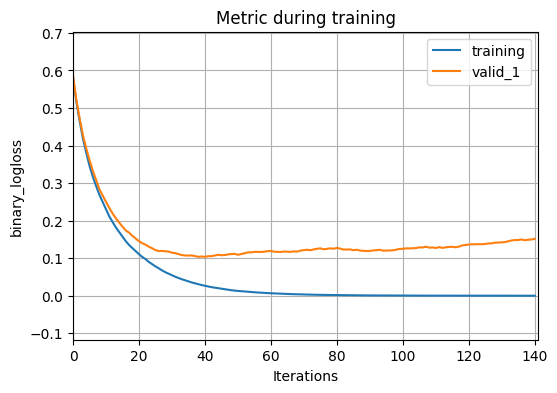

In [ ]:
lgb.plot_metric(evaluations_result, figsize=(6,4));

In [ ]:
# 評価指標を複数指定した場合
params = {
    "objective": "binary",
    "metric": ["binary_logloss", "auc"], # リストで評価指標を複数指定
    "verbosity": -1,
}
evaluations_result={} # 評価結果を入れる辞書
booster = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=1000,
    callbacks=[
        lgb.early_stopping(100),
        lgb.record_evaluation(evaluations_result) # 評価結果を辞書に入れる
    ],
)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.02643	training's auc: 1	valid_1's binary_logloss: 0.103654	valid_1's auc: 0.994174


<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

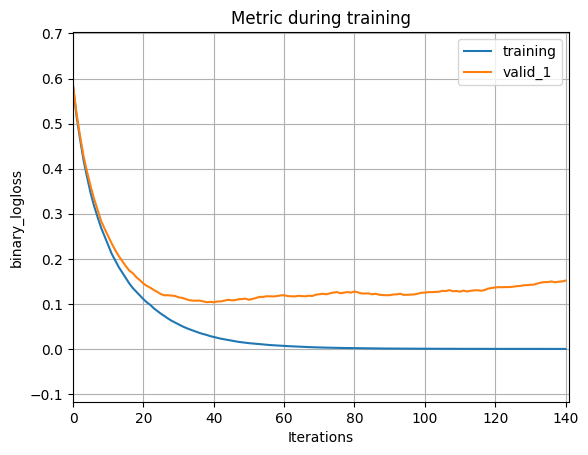

In [ ]:
# metricオプションで可視化する指標を指定
lgb.plot_metric(evaluations_result,metric='binary_logloss')

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='auc'>

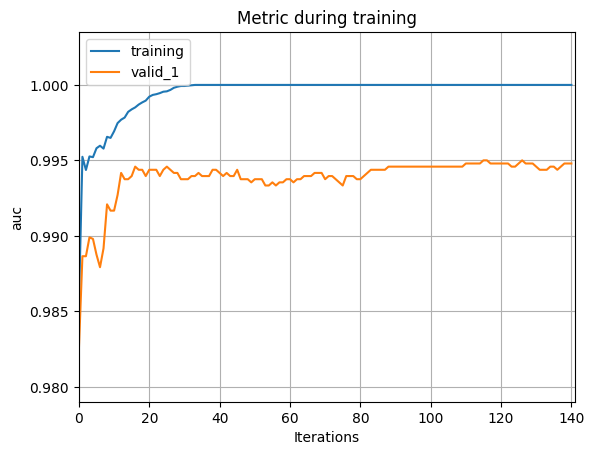

In [ ]:
# metricオプションで可視化する指標を指定
lgb.plot_metric(evaluations_result,metric='auc')

### sklearn APIの場合

sklearn APIでモデルを作成した場合は、plot_metricにモデルを入れると可視化されます。

In [ ]:
# sklearn APIで使う場合
import lightgbm as lgb
import sklearn.datasets
from sklearn.model_selection import train_test_split

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True,as_frame=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)

model = lgb.LGBMClassifier(n_estimators=1000,verbosity=-1)
model.fit(
    train_x, train_y,
    eval_set=[(train_x, train_y),(val_x, val_y)],
    eval_metric="binary_logloss",
    callbacks=[lgb.early_stopping(100)]
)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654


LGBMClassifier(n_estimators=1000, verbosity=-1)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

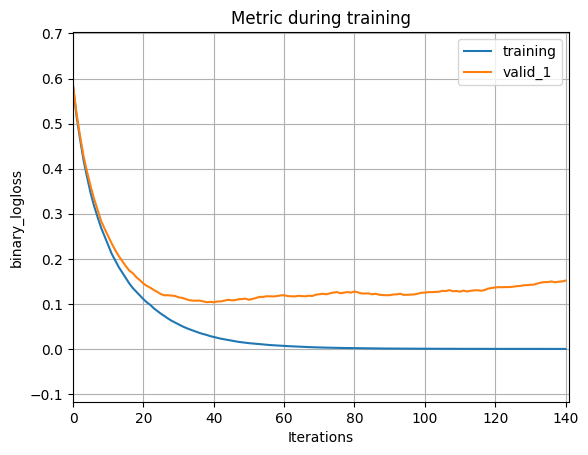

In [ ]:
# sklearn APIの場合、モデルを入力すれば可視化される
lgb.plot_metric(model)

## plot_importance：重要度の可視化

In [ ]:
import lightgbm as lgb
import sklearn.datasets
from sklearn.model_selection import train_test_split

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
}
model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)],
)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.000462198	valid_1's binary_logloss: 0.12469
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654


lightgbmのplot_importanceメソッドを使うと
重要度を可視化することができて便利です。

公式ドキュメント
https://lightgbm.readthedocs.io/en/stable/pythonapi/lightgbm.plot_importance.html

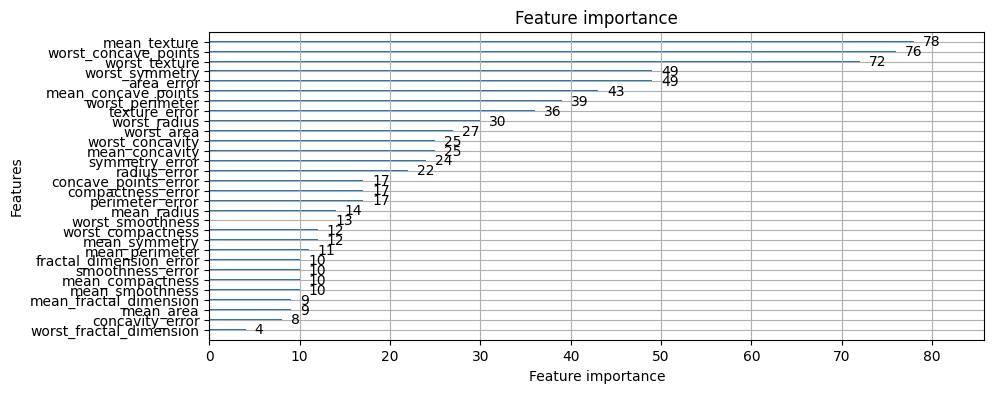

In [ ]:
lgb.plot_importance(booster,figsize=(10,4));

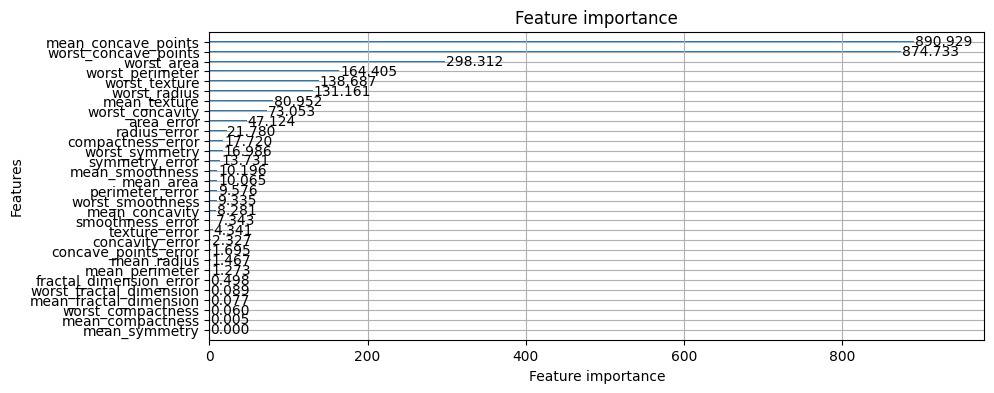

In [ ]:
lgb.plot_importance(booster,importance_type='gain', figsize=(10,4));

## plot_split_value_histogram：分岐に使われる値の可視化

lightgbmのplot_split_value_histogramを使うと、指定した特徴量がどの値で分岐に使われているか、  
その出現頻度を可視化することができます。  

モデルを解釈するのに役立つかもしれません。

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_split_value_histogram.html

In [ ]:
import lightgbm as lgb
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True,as_frame=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,

    "seed": 42,
    "deterministic":True,
    "force_col_wise":True
}
booster = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)],
)

Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.000462198	valid_1's binary_logloss: 0.12469
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654


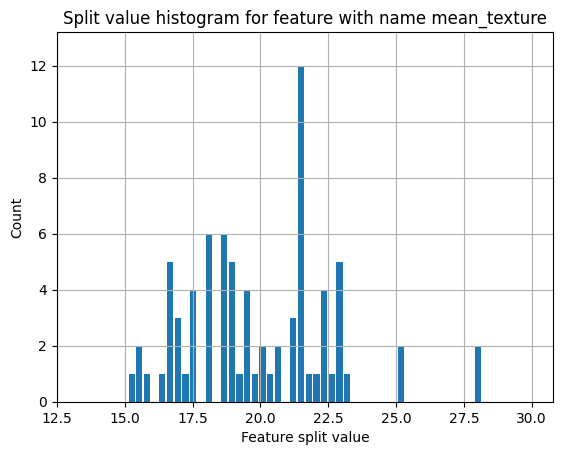

In [ ]:
lgb.plot_split_value_histogram(booster,feature='mean_texture'); # featureに確認したい列名(or番号)を指定

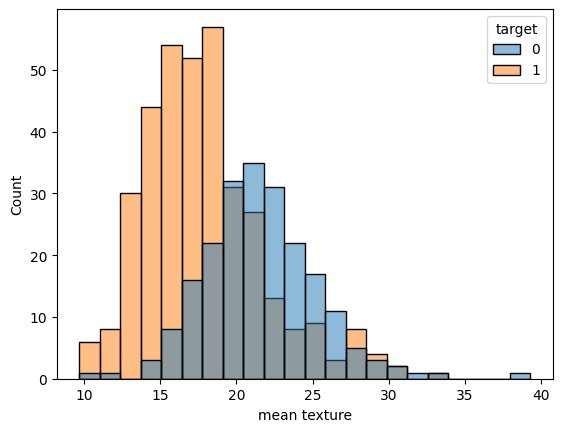

In [ ]:
# 分岐に使われている値が妥当そうか確認してみる
sns.histplot(x=data['mean texture'],hue=target);

### get_split_value_histogram：分岐に使われる値の取得

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Booster.html#lightgbm.Booster.get_split_value_histogram

get_split_value_histogramでグラフではなく値で取得できます

In [ ]:
sp_val = booster.get_split_value_histogram(feature='mean_texture')
sp_val

(array([ 1,  2,  1,  0,  1,  5,  3,  1,  4,  0,  6,  0,  6,  5,  1,  4,  1,
         2,  1,  2,  0,  3, 12,  1,  1,  4,  1,  5,  1,  0,  0,  0,  0,  0,
         0,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2]),
 array([15.105     , 15.38902174, 15.67304348, 15.95706522, 16.24108696,
        16.5251087 , 16.80913043, 17.09315217, 17.37717391, 17.66119565,
        17.94521739, 18.22923913, 18.51326087, 18.79728261, 19.08130435,
        19.36532609, 19.64934783, 19.93336957, 20.2173913 , 20.50141304,
        20.78543478, 21.06945652, 21.35347826, 21.6375    , 21.92152174,
        22.20554348, 22.48956522, 22.77358696, 23.0576087 , 23.34163043,
        23.62565217, 23.90967391, 24.19369565, 24.47771739, 24.76173913,
        25.04576087, 25.32978261, 25.61380435, 25.89782609, 26.18184783,
        26.46586957, 26.7498913 , 27.03391304, 27.31793478, 27.60195652,
        27.88597826, 28.17      ]))

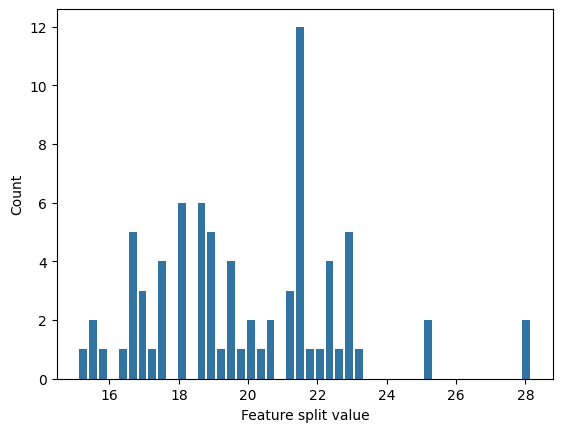

In [ ]:
counts = sp_val[0]
bins = sp_val[1]
hist_df = pd.DataFrame({
    'bin_center': (bins[:-1] + bins[1:]) / 2,
    'count': counts
})
sns.barplot(x='bin_center', y='count', data=hist_df, native_scale=True)
plt.xlabel('Feature split value')
plt.ylabel('Count')
plt.show()

## plot_tree：決定木の可視化

lightgbmのcreate_tree_digraphで、各決定木を可視化できます。
これもモデルの解釈に役立ちそうです。
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.create_tree_digraph.html

In [ ]:
import lightgbm as lgb
import sklearn.datasets
from sklearn.model_selection import train_test_split

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True,as_frame=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
}
booster = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100)]
)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654


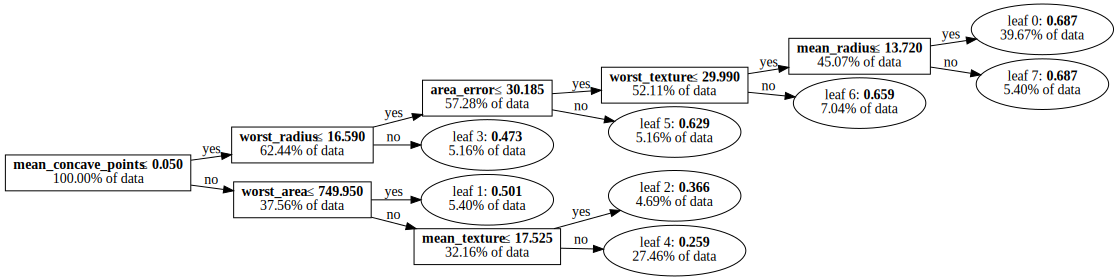

In [ ]:
lgb.create_tree_digraph(booster,tree_index=0, show_info=["data_percentage"])

なお、lightgbmの木の可視化には、
plot_treeという関数もありますが、  
これはcreate_tree_digraphの結果をpng画像に変換してmatplotlibで表示しているだけのようです。

直接Jupyterにレンダリングした方がきれいに表示できるのでcreate_tree_digraph使う方がおすすめです。
https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.plot_tree.html


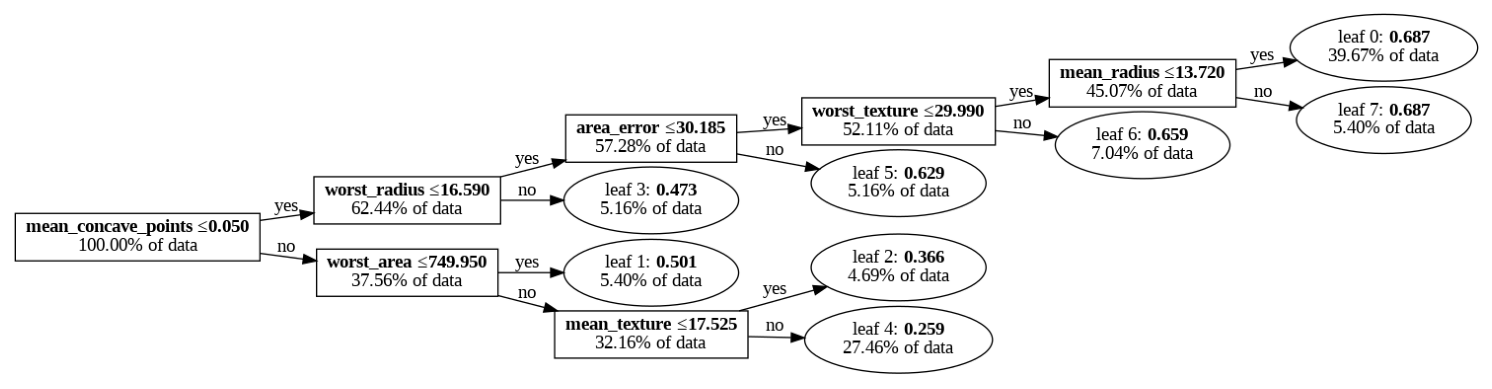

In [ ]:
lgb.plot_tree(booster,tree_index=0, show_info=["data_percentage"],figsize=(19,5));

### trees_to_dataframe：決定木をテーブル形式で取得

lightgbm.Boosterのtrees_to_dataframe()メソッドを使うと、木構造をpandasのDataFrameで返してくれます。  
これもモデルの解釈に役立てられそうです。

https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.Booster.html#lightgbm.Booster.trees_to_dataframe

In [ ]:
booster = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100)]
)

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654


In [ ]:
booster.trees_to_dataframe()

,tree_index,node_depth,node_index,left_child,right_child,parent_index,split_feature,split_gain,threshold,decision_type,missing_direction,missing_type,value,weight,count
0,0,1,0-S0,0-S2,0-S1,None,mean_concave_points,2.930880e+02,0.050125,<=,left,None,0.528392,0.000000,426
1,0,2,0-S2,0-S4,0-L3,0-S0,worst_radius,1.988610e+01,16.590000,<=,left,None,0.661568,62.066100,266
2,0,3,0-S4,0-S5,0-L5,0-S2,area_error,1.391370e+00,30.185000,<=,left,None,0.678565,56.932800,244
3,0,4,0-S5,0-S6,0-L6,0-S4,worst_texture,4.942130e-01,29.990000,<=,left,None,0.683486,51.799500,222
4,0,5,0-S6,0-L0,0-L7,0-S5,mean_radius,1.421090e-14,13.720000,<=,left,None,0.687347,44.799600,192
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1592,40,8,40-S19,40-L16,40-S23,40-S15,worst_perimeter,3.027200e-06,139.850000,<=,left,None,-0.101307,0.891797,74
1593,40,9,40-L16,None,None,40-S19,None,NaN,NaN,None,None,None,-0.101585,0.272532,20
1594,40,9,40-S23,40-L20,40-L24,40-S19,mean_texture,1.628320e-07,22.030000,<=,left,None,-0.101185,0.619266,54
1595,40,10,40-L20,None,None,40-S23,None,NaN,NaN,None,None,None,-0.101128,0.275086,25


# Optuna：ハイパーパラメータ自動チューニング

## LightGBMTuner



https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.integration.lightgbm.LightGBMTuner.html

LightGBMTunerを使うとoptunaを使って自動パラメータチューニングができます。
- runで学習とパラーメタチューニング開始
  - 得られるオブジェクトから取得できるもの
    - best_params：チューニングの結果得られた最良のパラメータ
    - get_best_booster()：そのパラメータで学習されたモデル

In [ ]:
import optuna.integration.lightgbm as lgb
import sklearn.datasets
from sklearn.model_selection import train_test_split
import optuna
optuna.logging.set_verbosity(-1)
data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}
tuner = lgb.LightGBMTuner(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)],
    show_progress_bar=False
)
tuner.run() # 学習とパラーメタチューニング開始

[I 2025-02-15 05:58:58,718] A new study created in memory with name: no-name-fdab25e0-8dec-404b-b012-bed0f6f78036
[I 2025-02-15 05:58:58,901] Trial 0 finished with value: 0.10365368587870742 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.10365368587870742.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000462198	valid_1's binary_logloss: 0.12469
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:58:59,038] Trial 1 finished with value: 0.09967463948028768 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.09967463948028768.
[I 2025-02-15 05:58:59,154] Trial 2 finished with value: 0.09106794311735114 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.09106794311735114.


[100]	valid_0's binary_logloss: 0.000652176	valid_1's binary_logloss: 0.107014
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.00291134	valid_1's binary_logloss: 0.0996746
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00067437	valid_1's binary_logloss: 0.105895
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.0151281	valid_1's binary_logloss: 0.0910679
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:58:59,296] Trial 3 finished with value: 0.09888564736737716 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.09106794311735114.
[I 2025-02-15 05:58:59,412] Trial 4 finished with value: 0.06920513067690687 and parameters: {'feature_fraction': 0.4}. Best is trial 4 with value: 0.06920513067690687.


[100]	valid_0's binary_logloss: 0.000571291	valid_1's binary_logloss: 0.102289
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.0201278	valid_1's binary_logloss: 0.0988856
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:58:59,605] Trial 5 finished with value: 0.10139190628425744 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 4 with value: 0.06920513067690687.


[100]	valid_0's binary_logloss: 0.000478885	valid_1's binary_logloss: 0.117873
Early stopping, best iteration is:
[56]	valid_0's binary_logloss: 0.00950971	valid_1's binary_logloss: 0.101392
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:58:59,813] Trial 6 finished with value: 0.10371303990875513 and parameters: {'feature_fraction': 0.8}. Best is trial 4 with value: 0.06920513067690687.
[I 2025-02-15 05:58:59,908] Trial 7 finished with value: 0.07147650172497075 and parameters: {'num_leaves': 15}. Best is trial 7 with value: 0.07147650172497075.


[100]	valid_0's binary_logloss: 0.000552204	valid_1's binary_logloss: 0.117536
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.00252485	valid_1's binary_logloss: 0.103713
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000779091	valid_1's binary_logloss: 0.0841271
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.00336348	valid_1's binary_logloss: 0.0714765
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:00,037] Trial 8 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 95}. Best is trial 8 with value: 0.06920513067690687.
[I 2025-02-15 05:59:00,158] Trial 9 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 142}. Best is trial 8 with value: 0.06920513067690687.


[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:00,324] Trial 10 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 253}. Best is trial 8 with value: 0.06920513067690687.


[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023


[I 2025-02-15 05:59:00,473] Trial 11 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 77}. Best is trial 8 with value: 0.06920513067690687.
[I 2025-02-15 05:59:00,628] Trial 12 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 149}. Best is trial 8 with value: 0.06920513067690687.


Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:00,780] Trial 13 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 73}. Best is trial 8 with value: 0.06920513067690687.
[I 2025-02-15 05:59:00,920] Trial 14 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 213}. Best is trial 8 with value: 0.06920513067690687.


[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051


[I 2025-02-15 05:59:01,045] Trial 15 finished with value: 0.07187212396056919 and parameters: {'num_leaves': 2}. Best is trial 8 with value: 0.06920513067690687.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0625089	valid_1's binary_logloss: 0.0900694
[200]	valid_0's binary_logloss: 0.0282984	valid_1's binary_logloss: 0.0808062
[300]	valid_0's binary_logloss: 0.0148849	valid_1's binary_logloss: 0.0756999
[400]	valid_0's binary_logloss: 0.00834898	valid_1's binary_logloss: 0.0739707
[500]	valid_0's binary_logloss: 0.00483136	valid_1's binary_logloss: 0.0732238
[600]	valid_0's binary_logloss: 0.00284742	valid_1's binary_logloss: 0.0731345
Early stopping, best iteration is:
[588]	valid_0's binary_logloss: 0.00303278	valid_1's binary_logloss: 0.0718721
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023


[I 2025-02-15 05:59:01,184] Trial 16 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 87}. Best is trial 8 with value: 0.06920513067690687.
[I 2025-02-15 05:59:01,332] Trial 17 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 188}. Best is trial 8 with value: 0.06920513067690687.


Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:01,484] Trial 18 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 113}. Best is trial 8 with value: 0.06920513067690687.


[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023


[I 2025-02-15 05:59:01,644] Trial 19 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 36}. Best is trial 8 with value: 0.06920513067690687.
[I 2025-02-15 05:59:01,793] Trial 20 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 185}. Best is trial 8 with value: 0.06920513067690687.


Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:01,926] Trial 21 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 149}. Best is trial 8 with value: 0.06920513067690687.
[I 2025-02-15 05:59:02,050] Trial 22 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 123}. Best is trial 8 with value: 0.06920513067690687.


[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:02,176] Trial 23 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 45}. Best is trial 8 with value: 0.06920513067690687.
[I 2025-02-15 05:59:02,308] Trial 24 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 103}. Best is trial 8 with value: 0.06920513067690687.


[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:02,446] Trial 25 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 152}. Best is trial 8 with value: 0.06920513067690687.
[I 2025-02-15 05:59:02,581] Trial 26 finished with value: 0.06920513067690687 and parameters: {'num_leaves': 185}. Best is trial 8 with value: 0.06920513067690687.


[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000807354	valid_1's binary_logloss: 0.0851023
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.00369537	valid_1's binary_logloss: 0.0692051


[I 2025-02-15 05:59:02,736] Trial 27 finished with value: 0.08293050798886754 and parameters: {'bagging_fraction': 0.9466000052668426, 'bagging_freq': 4}. Best is trial 27 with value: 0.08293050798886754.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000978548	valid_1's binary_logloss: 0.0977769
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.00701246	valid_1's binary_logloss: 0.0829305
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:02,845] Trial 28 finished with value: 0.06562459330508015 and parameters: {'bagging_fraction': 0.4115530118805466, 'bagging_freq': 1}. Best is trial 28 with value: 0.06562459330508015.
[I 2025-02-15 05:59:02,934] Trial 29 finished with value: 0.06334541293594137 and parameters: {'bagging_fraction': 0.44401657797907823, 'bagging_freq': 1}. Best is trial 29 with value: 0.06334541293594137.


[100]	valid_0's binary_logloss: 0.0085124	valid_1's binary_logloss: 0.0745819
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.0224376	valid_1's binary_logloss: 0.0656246
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0070821	valid_1's binary_logloss: 0.0748026
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.0164266	valid_1's binary_logloss: 0.0633454
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0108636	valid_1's binary_logloss: 0.0772223
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.0172478	valid_1's binary_logloss: 0.069969


[I 2025-02-15 05:59:03,026] Trial 30 finished with value: 0.06996895521694563 and parameters: {'bagging_fraction': 0.4024652297677235, 'bagging_freq': 1}. Best is trial 29 with value: 0.06334541293594137.
[I 2025-02-15 05:59:03,107] Trial 31 finished with value: 0.0699595093688812 and parameters: {'bagging_fraction': 0.4080992847803487, 'bagging_freq': 1}. Best is trial 29 with value: 0.06334541293594137.
[I 2025-02-15 05:59:03,230] Trial 32 finished with value: 0.06508512839450974 and parameters: {'bagging_fraction': 0.5969969310208576, 'bagging_freq': 1}. Best is trial 29 with value: 0.06334541293594137.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00971937	valid_1's binary_logloss: 0.0790956
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.0191434	valid_1's binary_logloss: 0.0699595
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00391804	valid_1's binary_logloss: 0.0791862
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.00976353	valid_1's binary_logloss: 0.0650851


[I 2025-02-15 05:59:03,327] Trial 33 finished with value: 0.07004151589134114 and parameters: {'bagging_fraction': 0.5586641670532112, 'bagging_freq': 1}. Best is trial 29 with value: 0.06334541293594137.
[I 2025-02-15 05:59:03,439] Trial 34 finished with value: 0.06697974834575879 and parameters: {'bagging_fraction': 0.5911511158636431, 'bagging_freq': 3}. Best is trial 29 with value: 0.06334541293594137.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00449663	valid_1's binary_logloss: 0.0723407
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.0114918	valid_1's binary_logloss: 0.0700415
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00445793	valid_1's binary_logloss: 0.0787556
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.0108794	valid_1's binary_logloss: 0.0669797


[I 2025-02-15 05:59:03,548] Trial 35 finished with value: 0.06448310226113449 and parameters: {'bagging_fraction': 0.5946680520998815, 'bagging_freq': 2}. Best is trial 29 with value: 0.06334541293594137.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00415632	valid_1's binary_logloss: 0.0744836
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.0109418	valid_1's binary_logloss: 0.0644831
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00443925	valid_1's binary_logloss: 0.0831264


[I 2025-02-15 05:59:03,687] Trial 36 finished with value: 0.0746549964214986 and parameters: {'bagging_fraction': 0.5854201979579668, 'bagging_freq': 1}. Best is trial 29 with value: 0.06334541293594137.
[I 2025-02-15 05:59:03,767] Trial 37 finished with value: 0.06905812204181577 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 0.06905812204181577.
[I 2025-02-15 05:59:03,870] Trial 38 finished with value: 0.05958496008536256 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 38 with value: 0.05958496008536256.


Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.00576207	valid_1's binary_logloss: 0.074655
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00713967	valid_1's binary_logloss: 0.0791223
Early stopping, best iteration is:
[74]	valid_0's binary_logloss: 0.0150155	valid_1's binary_logloss: 0.0690581
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.007347	valid_1's binary_logloss: 0.0725202
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.0178879	valid_1's binary_logloss: 0.059585


[I 2025-02-15 05:59:03,950] Trial 39 finished with value: 0.06334541293594137 and parameters: {'feature_fraction': 0.41600000000000004}. Best is trial 38 with value: 0.05958496008536256.
[I 2025-02-15 05:59:04,076] Trial 40 finished with value: 0.0688541631785362 and parameters: {'lambda_l1': 1.447122766936006e-07, 'lambda_l2': 7.308673475890728}. Best is trial 40 with value: 0.0688541631785362.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0070821	valid_1's binary_logloss: 0.0748026
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.0164266	valid_1's binary_logloss: 0.0633454
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0701899	valid_1's binary_logloss: 0.0797161
[200]	valid_0's binary_logloss: 0.0396628	valid_1's binary_logloss: 0.0696807
[300]	valid_0's binary_logloss: 0.0281844	valid_1's binary_logloss: 0.0708813
Early stopping, best iteration is:
[256]	valid_0's binary_logloss: 0.0324352	valid_1's binary_logloss: 0.0688542


[I 2025-02-15 05:59:04,247] Trial 41 finished with value: 0.13708822138388946 and parameters: {'lambda_l1': 8.412011849264685, 'lambda_l2': 1.2821331669984234e-08}. Best is trial 40 with value: 0.0688541631785362.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.16807	valid_1's binary_logloss: 0.155943
[200]	valid_0's binary_logloss: 0.158511	valid_1's binary_logloss: 0.147239
[300]	valid_0's binary_logloss: 0.155596	valid_1's binary_logloss: 0.144992
[400]	valid_0's binary_logloss: 0.153268	valid_1's binary_logloss: 0.143069
[500]	valid_0's binary_logloss: 0.152957	valid_1's binary_logloss: 0.142746
[600]	valid_0's binary_logloss: 0.152235	valid_1's binary_logloss: 0.14195
[700]	valid_0's binary_logloss: 0.150852	valid_1's binary_logloss: 0.140534
[800]	valid_0's binary_logloss: 0.150272	valid_1's binary_logloss: 0.13962
[900]	valid_0's binary_logloss: 0.148568	valid_1's binary_logloss: 0.138366
[1000]	valid_0's binary_logloss: 0.147589	valid_1's binary_logloss: 0.137088
Did not meet early stopping. Best iteration is:
[959]	valid_0's binary_logloss: 0.147589	valid_1's binary_logloss: 0.137088
Training until validation scores don't improve for 100 r

[I 2025-02-15 05:59:04,330] Trial 42 finished with value: 0.0630116572179865 and parameters: {'lambda_l1': 0.039589397058568364, 'lambda_l2': 0.00017820861292860429}. Best is trial 42 with value: 0.0630116572179865.
[I 2025-02-15 05:59:04,403] Trial 43 finished with value: 0.06144227154578796 and parameters: {'lambda_l1': 0.1198125345458145, 'lambda_l2': 0.00012436048442304043}. Best is trial 43 with value: 0.06144227154578796.
[I 2025-02-15 05:59:04,477] Trial 44 finished with value: 0.059413347281599214 and parameters: {'lambda_l1': 0.2109570059230127, 'lambda_l2': 0.00013175792360715176}. Best is trial 44 with value: 0.059413347281599214.


Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.0265107	valid_1's binary_logloss: 0.0630117
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0119953	valid_1's binary_logloss: 0.0658587
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.0172555	valid_1's binary_logloss: 0.0614423
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0138065	valid_1's binary_logloss: 0.0623938
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.0200907	valid_1's binary_logloss: 0.0594133
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.012653	valid_1's binary_logloss: 0.0628913


[I 2025-02-15 05:59:04,551] Trial 45 finished with value: 0.0592187132986585 and parameters: {'lambda_l1': 0.16059070851860735, 'lambda_l2': 0.0001356003818644778}. Best is trial 45 with value: 0.0592187132986585.
[I 2025-02-15 05:59:04,675] Trial 46 finished with value: 0.060326890777987634 and parameters: {'lambda_l1': 0.18032819923304588, 'lambda_l2': 9.702588495524397e-05}. Best is trial 45 with value: 0.0592187132986585.


Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.0261397	valid_1's binary_logloss: 0.0592187
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0131755	valid_1's binary_logloss: 0.064121
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.0262198	valid_1's binary_logloss: 0.0603269
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00948923	valid_1's binary_logloss: 0.0735446
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.0166132	valid_1's binary_logloss: 0.0650259


[I 2025-02-15 05:59:04,755] Trial 47 finished with value: 0.0650259023992499 and parameters: {'lambda_l1': 0.05266224537770313, 'lambda_l2': 0.00014045362354536982}. Best is trial 45 with value: 0.0592187132986585.
[I 2025-02-15 05:59:04,841] Trial 48 finished with value: 0.059985041792655534 and parameters: {'lambda_l1': 0.18310820271352382, 'lambda_l2': 0.00012374120115553173}. Best is trial 45 with value: 0.0592187132986585.
[I 2025-02-15 05:59:04,927] Trial 49 finished with value: 0.059549443157980136 and parameters: {'lambda_l1': 0.21943496199448906, 'lambda_l2': 3.578535686978501e-05}. Best is trial 45 with value: 0.0592187132986585.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.01361	valid_1's binary_logloss: 0.0612333
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.0146559	valid_1's binary_logloss: 0.059985
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0147685	valid_1's binary_logloss: 0.0609903
[200]	valid_0's binary_logloss: 0.00564659	valid_1's binary_logloss: 0.0654045
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.0140314	valid_1's binary_logloss: 0.0595494
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0556324	valid_1's binary_logloss: 0.0749809


[I 2025-02-15 05:59:05,061] Trial 50 finished with value: 0.06894081708583287 and parameters: {'lambda_l1': 1.8614034526343088, 'lambda_l2': 3.532510116422294e-06}. Best is trial 45 with value: 0.0592187132986585.
[I 2025-02-15 05:59:05,135] Trial 51 finished with value: 0.06155118657861261 and parameters: {'lambda_l1': 0.03362493584385771, 'lambda_l2': 6.763998833265609e-05}. Best is trial 45 with value: 0.0592187132986585.


[200]	valid_0's binary_logloss: 0.0420463	valid_1's binary_logloss: 0.0714429
[300]	valid_0's binary_logloss: 0.0385697	valid_1's binary_logloss: 0.0703691
[400]	valid_0's binary_logloss: 0.0359561	valid_1's binary_logloss: 0.0695749
[500]	valid_0's binary_logloss: 0.0343988	valid_1's binary_logloss: 0.0690955
Early stopping, best iteration is:
[453]	valid_0's binary_logloss: 0.035156	valid_1's binary_logloss: 0.0689408
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00830483	valid_1's binary_logloss: 0.0730934
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.0202003	valid_1's binary_logloss: 0.0615512
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0134582	valid_1's binary_logloss: 0.0641667


[I 2025-02-15 05:59:05,216] Trial 52 finished with value: 0.05963034748618566 and parameters: {'lambda_l1': 0.20878728818448092, 'lambda_l2': 1.1926428142229112e-05}. Best is trial 45 with value: 0.0592187132986585.
[I 2025-02-15 05:59:05,297] Trial 53 finished with value: 0.05813170323672657 and parameters: {'lambda_l1': 0.003065494380245861, 'lambda_l2': 3.2302110585247302e-06}. Best is trial 53 with value: 0.05813170323672657.
[I 2025-02-15 05:59:05,378] Trial 54 finished with value: 0.06289965424835077 and parameters: {'lambda_l1': 0.0007512937493856766, 'lambda_l2': 1.3220864374391769e-06}. Best is trial 53 with value: 0.05813170323672657.


Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.0193742	valid_1's binary_logloss: 0.0596303
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0074614	valid_1's binary_logloss: 0.0682387
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.0158239	valid_1's binary_logloss: 0.0581317
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00701729	valid_1's binary_logloss: 0.0760419
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.0177976	valid_1's binary_logloss: 0.0628997
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:05,467] Trial 55 finished with value: 0.057886627427962946 and parameters: {'lambda_l1': 0.0022803207334591027, 'lambda_l2': 1.8170674173230776e-06}. Best is trial 55 with value: 0.057886627427962946.
[I 2025-02-15 05:59:05,556] Trial 56 finished with value: 0.06651071708225775 and parameters: {'lambda_l1': 0.0006603893558603172, 'lambda_l2': 3.9282494862866335e-07}. Best is trial 55 with value: 0.057886627427962946.


[100]	valid_0's binary_logloss: 0.0072056	valid_1's binary_logloss: 0.0717895
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.0179364	valid_1's binary_logloss: 0.0578866
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00729543	valid_1's binary_logloss: 0.0767914
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.0188382	valid_1's binary_logloss: 0.0665107
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00738989	valid_1's binary_logloss: 0.0729916


[I 2025-02-15 05:59:05,675] Trial 57 finished with value: 0.06297722791807454 and parameters: {'lambda_l1': 0.0025342361330628173, 'lambda_l2': 0.006684453892186231}. Best is trial 55 with value: 0.057886627427962946.
[I 2025-02-15 05:59:05,761] Trial 58 finished with value: 0.06232554647773599 and parameters: {'lambda_l1': 2.418521448035019e-05, 'lambda_l2': 1.5338865540469682e-07}. Best is trial 55 with value: 0.057886627427962946.
[I 2025-02-15 05:59:05,844] Trial 59 finished with value: 0.0651672782777711 and parameters: {'lambda_l1': 0.005210028404781963, 'lambda_l2': 0.0049135864872116766}. Best is trial 55 with value: 0.057886627427962946.


Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.0145483	valid_1's binary_logloss: 0.0629772
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00747662	valid_1's binary_logloss: 0.0713667
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.014287	valid_1's binary_logloss: 0.0623255
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00714569	valid_1's binary_logloss: 0.0754344
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.0171736	valid_1's binary_logloss: 0.0651673
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:05,935] Trial 60 finished with value: 0.05945369029263588 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.05945369029263588.
[I 2025-02-15 05:59:06,047] Trial 61 finished with value: 0.06957910737232839 and parameters: {'min_child_samples': 100}. Best is trial 60 with value: 0.05945369029263588.


[100]	valid_0's binary_logloss: 0.034445	valid_1's binary_logloss: 0.06781
[200]	valid_0's binary_logloss: 0.00874239	valid_1's binary_logloss: 0.0697344
Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.0209778	valid_1's binary_logloss: 0.0594537
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.274041	valid_1's binary_logloss: 0.246436
[200]	valid_0's binary_logloss: 0.181769	valid_1's binary_logloss: 0.145909
[300]	valid_0's binary_logloss: 0.143588	valid_1's binary_logloss: 0.10938
[400]	valid_0's binary_logloss: 0.126399	valid_1's binary_logloss: 0.0943751
[500]	valid_0's binary_logloss: 0.119895	valid_1's binary_logloss: 0.0869653
[600]	valid_0's binary_logloss: 0.112663	valid_1's binary_logloss: 0.0823176
[700]	valid_0's binary_logloss: 0.105845	valid_1's binary_logloss: 0.0768464
[800]	valid_0's binary_logloss: 0.100689	valid_1's binary_logloss: 0.0700075
[900]	valid_0's binary_logloss: 0.0951931	valid_1's binary_

[I 2025-02-15 05:59:06,147] Trial 62 finished with value: 0.05742180191431429 and parameters: {'min_child_samples': 5}. Best is trial 62 with value: 0.05742180191431429.
[I 2025-02-15 05:59:06,231] Trial 63 finished with value: 0.06091019357315468 and parameters: {'min_child_samples': 10}. Best is trial 62 with value: 0.05742180191431429.
[I 2025-02-15 05:59:06,293] Trial 64 finished with value: 0.07019491427484138 and parameters: {'min_child_samples': 25}. Best is trial 62 with value: 0.05742180191431429.


[100]	valid_0's binary_logloss: 0.00284403	valid_1's binary_logloss: 0.0778417
Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.00669731	valid_1's binary_logloss: 0.0574218
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00448297	valid_1's binary_logloss: 0.0734796
Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.012099	valid_1's binary_logloss: 0.0609102
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00929928	valid_1's binary_logloss: 0.0746002
Early stopping, best iteration is:
[58]	valid_0's binary_logloss: 0.0336543	valid_1's binary_logloss: 0.0701949


In [ ]:
# パラメータ
tuner.best_params

{'objective': 'binary',
 'metric': 'binary_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'lambda_l1': 0.0022803207334591027,
 'lambda_l2': 1.8170674173230776e-06,
 'num_leaves': 31,
 'feature_fraction': 0.48000000000000004,
 'bagging_fraction': 0.44401657797907823,
 'bagging_freq': 1,
 'min_child_samples': 5}

In [ ]:
# 最良のパラメタで学習されたモデルを取得
model = tuner.get_best_booster()

In [ ]:
model.predict(val_x)[:3]

array([9.97661147e-01, 4.33064785e-04, 7.19724539e-04])

## LightGBMTunerCV

https://optuna.readthedocs.io/en/v2.0.0/reference/generated/optuna.integration.lightgbm.LightGBMTunerCV.html

optuna.integrationのLightGBMTunerCVを使うと、交差検証してパラメータチューニングを行います。

チューニングしたパラメータが得られ、return_cvbooster=Trueとすれば、
そのパラメータで学習されたモデルを取得することもできます。

サンプルコード  
https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_tuner_cv.py

In [ ]:
import optuna.integration.lightgbm as lgb
import sklearn.datasets
from sklearn.model_selection import KFold

In [ ]:
data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
dtrain = lgb.Dataset(data, label=target)
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}
tuner = lgb.LightGBMTunerCV(
    params,
    dtrain,
    folds=KFold(n_splits=3),
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)],
    show_progress_bar=False,
    return_cvbooster=True
)
tuner.run()

[I 2025-02-15 05:59:06,362] A new study created in memory with name: no-name-e709a8d8-4ea0-471c-aa7e-913114525962
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:86: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.13854 + 0.087254


[I 2025-02-15 05:59:09,025] Trial 0 finished with value: 0.12025281209292614 and parameters: {'feature_fraction': 1.0}. Best is trial 0 with value: 0.12025281209292614.


Early stopping, best iteration is:
[49]	cv_agg's valid binary_logloss: 0.120253 + 0.062858
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:09,412] Trial 1 finished with value: 0.11030669491510992 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.11030669491510992.


[100]	cv_agg's valid binary_logloss: 0.130926 + 0.0846482
Early stopping, best iteration is:
[50]	cv_agg's valid binary_logloss: 0.110307 + 0.0539841
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:09,796] Trial 2 finished with value: 0.10476251316660355 and parameters: {'feature_fraction': 0.5}. Best is trial 2 with value: 0.10476251316660355.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:10,283] Trial 3 finished with value: 0.1098395780651082 and parameters: {'feature_fraction': 0.7}. Best is trial 2 with value: 0.10476251316660355.


[100]	cv_agg's valid binary_logloss: 0.127943 + 0.0796452
Early stopping, best iteration is:
[61]	cv_agg's valid binary_logloss: 0.10984 + 0.0590742
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:10,636] Trial 4 finished with value: 0.10766184362100834 and parameters: {'feature_fraction': 0.4}. Best is trial 2 with value: 0.10476251316660355.


[100]	cv_agg's valid binary_logloss: 0.119372 + 0.0747948
Early stopping, best iteration is:
[61]	cv_agg's valid binary_logloss: 0.107662 + 0.0548315
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:11,193] Trial 5 finished with value: 0.11425826711453106 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 2 with value: 0.10476251316660355.


[100]	cv_agg's valid binary_logloss: 0.129458 + 0.0820114
Early stopping, best iteration is:
[70]	cv_agg's valid binary_logloss: 0.114258 + 0.0664533
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:11,678] Trial 6 finished with value: 0.11421610134146287 and parameters: {'feature_fraction': 0.8}. Best is trial 2 with value: 0.10476251316660355.


[100]	cv_agg's valid binary_logloss: 0.136798 + 0.0943453
Early stopping, best iteration is:
[50]	cv_agg's valid binary_logloss: 0.114216 + 0.0589948
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:12,088] Trial 7 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 183}. Best is trial 7 with value: 0.10476251316660355.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093


[I 2025-02-15 05:59:13,589] Trial 8 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 196}. Best is trial 7 with value: 0.10476251316660355.


Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093


[I 2025-02-15 05:59:22,651] Trial 9 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 74}. Best is trial 7 with value: 0.10476251316660355.


Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.103914 + 0.0587365


[I 2025-02-15 05:59:25,076] Trial 10 finished with value: 0.10275741775346992 and parameters: {'num_leaves': 4}. Best is trial 10 with value: 0.10275741775346992.


Early stopping, best iteration is:
[90]	cv_agg's valid binary_logloss: 0.102757 + 0.0559683
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.120071 + 0.0786307


[I 2025-02-15 05:59:27,380] Trial 11 finished with value: 0.10492248865621608 and parameters: {'num_leaves': 14}. Best is trial 10 with value: 0.10275741775346992.


Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104922 + 0.0522726
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:29,127] Trial 12 finished with value: 0.10545535208001122 and parameters: {'num_leaves': 5}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.112268 + 0.065008
Early stopping, best iteration is:
[74]	cv_agg's valid binary_logloss: 0.105455 + 0.052644
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:29,509] Trial 13 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 106}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:29,965] Trial 14 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 245}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:30,331] Trial 15 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 64}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:30,753] Trial 16 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 147}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:31,145] Trial 17 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 53}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:31,522] Trial 18 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 118}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093


[I 2025-02-15 05:59:32,053] Trial 19 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 38}. Best is trial 10 with value: 0.10275741775346992.


Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:34,295] Trial 20 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 92}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:34,698] Trial 21 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 167}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:35,084] Trial 22 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 206}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:35,482] Trial 23 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 251}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:35,868] Trial 24 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 171}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:36,288] Trial 25 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 218}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:36,667] Trial 26 finished with value: 0.10476251316660355 and parameters: {'num_leaves': 143}. Best is trial 10 with value: 0.10275741775346992.


[100]	cv_agg's valid binary_logloss: 0.119285 + 0.0771093
Early stopping, best iteration is:
[56]	cv_agg's valid binary_logloss: 0.104763 + 0.0524322
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:36,840] Trial 27 finished with value: 0.10547334719326203 and parameters: {'bagging_fraction': 0.9861269136389046, 'bagging_freq': 5}. Best is trial 27 with value: 0.10547334719326203.


[100]	cv_agg's valid binary_logloss: 0.106444 + 0.056662
Early stopping, best iteration is:
[85]	cv_agg's valid binary_logloss: 0.105473 + 0.052022
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.110281 + 0.0639007


[I 2025-02-15 05:59:36,996] Trial 28 finished with value: 0.09949385247279692 and parameters: {'bagging_fraction': 0.43168597422618016, 'bagging_freq': 1}. Best is trial 28 with value: 0.09949385247279692.
[I 2025-02-15 05:59:37,140] Trial 29 finished with value: 0.10026973511599781 and parameters: {'bagging_fraction': 0.4475831279089103, 'bagging_freq': 1}. Best is trial 28 with value: 0.09949385247279692.


Early stopping, best iteration is:
[65]	cv_agg's valid binary_logloss: 0.0994939 + 0.0491166
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.109033 + 0.0631426
Early stopping, best iteration is:
[67]	cv_agg's valid binary_logloss: 0.10027 + 0.0526146
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:37,311] Trial 30 finished with value: 0.09731020182862894 and parameters: {'bagging_fraction': 0.4223424703035075, 'bagging_freq': 1}. Best is trial 30 with value: 0.09731020182862894.


[100]	cv_agg's valid binary_logloss: 0.107724 + 0.062801
Early stopping, best iteration is:
[71]	cv_agg's valid binary_logloss: 0.0973102 + 0.0559897
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.10375 + 0.0596543
Early stopping, best iteration is:
[68]	cv_agg's valid binary_logloss: 0.0963618 + 0.0476843


[I 2025-02-15 05:59:37,464] Trial 31 finished with value: 0.09636177165048825 and parameters: {'bagging_fraction': 0.4201624374210403, 'bagging_freq': 1}. Best is trial 31 with value: 0.09636177165048825.
[I 2025-02-15 05:59:37,661] Trial 32 finished with value: 0.09929801293409636 and parameters: {'bagging_fraction': 0.40345288432977566, 'bagging_freq': 1}. Best is trial 31 with value: 0.09636177165048825.


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.106853 + 0.0649858
Early stopping, best iteration is:
[81]	cv_agg's valid binary_logloss: 0.099298 + 0.0563374
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:37,824] Trial 33 finished with value: 0.0921060109950224 and parameters: {'bagging_fraction': 0.40827307337534524, 'bagging_freq': 1}. Best is trial 33 with value: 0.0921060109950224.


[100]	cv_agg's valid binary_logloss: 0.0992784 + 0.0584689
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.092106 + 0.0508379
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.102888 + 0.065223


[I 2025-02-15 05:59:37,982] Trial 34 finished with value: 0.09477155728409115 and parameters: {'bagging_fraction': 0.40259223692362256, 'bagging_freq': 1}. Best is trial 33 with value: 0.0921060109950224.
[I 2025-02-15 05:59:38,144] Trial 35 finished with value: 0.09424907778546976 and parameters: {'bagging_fraction': 0.40212196913048553, 'bagging_freq': 1}. Best is trial 33 with value: 0.0921060109950224.


Early stopping, best iteration is:
[81]	cv_agg's valid binary_logloss: 0.0947716 + 0.05475
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.102876 + 0.0645341
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0942491 + 0.0547959
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:38,320] Trial 36 finished with value: 0.10029115726750841 and parameters: {'bagging_fraction': 0.5702613394198188, 'bagging_freq': 3}. Best is trial 33 with value: 0.0921060109950224.


[100]	cv_agg's valid binary_logloss: 0.102083 + 0.054463
Early stopping, best iteration is:
[76]	cv_agg's valid binary_logloss: 0.100291 + 0.0478891
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0976763 + 0.0464377


[I 2025-02-15 05:59:38,473] Trial 37 finished with value: 0.08905860425029266 and parameters: {'feature_fraction': 0.5479999999999999}. Best is trial 37 with value: 0.08905860425029266.
[I 2025-02-15 05:59:38,636] Trial 38 finished with value: 0.09884179352786744 and parameters: {'feature_fraction': 0.45199999999999996}. Best is trial 37 with value: 0.08905860425029266.


Early stopping, best iteration is:
[77]	cv_agg's valid binary_logloss: 0.0890586 + 0.0376132
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.105316 + 0.0653112
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0988418 + 0.0572309
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:38,788] Trial 39 finished with value: 0.08792669132628889 and parameters: {'feature_fraction': 0.58}. Best is trial 39 with value: 0.08792669132628889.


[100]	cv_agg's valid binary_logloss: 0.094632 + 0.0505894
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879267 + 0.0449807
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.113372 + 0.0704931


[I 2025-02-15 05:59:38,938] Trial 40 finished with value: 0.10614098074527807 and parameters: {'feature_fraction': 0.42}. Best is trial 39 with value: 0.08792669132628889.
[I 2025-02-15 05:59:39,082] Trial 41 finished with value: 0.0921060109950224 and parameters: {'feature_fraction': 0.484}. Best is trial 39 with value: 0.08792669132628889.


Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.106141 + 0.062441
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0992784 + 0.0584689
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.092106 + 0.0508379
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:39,251] Trial 42 finished with value: 0.0921060109950224 and parameters: {'feature_fraction': 0.516}. Best is trial 39 with value: 0.08792669132628889.


[100]	cv_agg's valid binary_logloss: 0.0992784 + 0.0584689
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.092106 + 0.0508379
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.094543 + 0.0504647


[I 2025-02-15 05:59:39,436] Trial 43 finished with value: 0.08792594959708609 and parameters: {'lambda_l1': 9.188450290527324e-05, 'lambda_l2': 2.0939674909709943e-06}. Best is trial 43 with value: 0.08792594959708609.


Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879259 + 0.0449782
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0945453 + 0.0504678
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879263 + 0.0449794


[I 2025-02-15 05:59:39,635] Trial 44 finished with value: 0.08792630172539022 and parameters: {'lambda_l1': 4.690715813114397e-05, 'lambda_l2': 2.2710686656034647e-06}. Best is trial 43 with value: 0.08792594959708609.
[I 2025-02-15 05:59:39,804] Trial 45 finished with value: 0.0879259049350211 and parameters: {'lambda_l1': 9.851825859031769e-05, 'lambda_l2': 1.2378842323833773e-06}. Best is trial 45 with value: 0.0879259049350211.


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0945427 + 0.0504643
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879259 + 0.044978
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:40,005] Trial 46 finished with value: 0.08792615382797407 and parameters: {'lambda_l1': 6.651416799627323e-05, 'lambda_l2': 1.5712526070485655e-06}. Best is trial 45 with value: 0.0879259049350211.


[100]	cv_agg's valid binary_logloss: 0.0945443 + 0.0504665
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879262 + 0.0449789
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0945445 + 0.0504668


[I 2025-02-15 05:59:40,186] Trial 47 finished with value: 0.08792618696718629 and parameters: {'lambda_l1': 6.282061659995161e-05, 'lambda_l2': 1.0863197187503637e-06}. Best is trial 45 with value: 0.0879259049350211.


Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879262 + 0.044979
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0945454 + 0.0504678


[I 2025-02-15 05:59:40,396] Trial 48 finished with value: 0.08792631150293967 and parameters: {'lambda_l1': 4.670867973114104e-05, 'lambda_l2': 1.3515988134139407e-06}. Best is trial 45 with value: 0.0879259049350211.
[I 2025-02-15 05:59:40,581] Trial 49 finished with value: 0.08792616505732576 and parameters: {'lambda_l1': 6.514875073492065e-05, 'lambda_l2': 1.5022506720538548e-06}. Best is trial 45 with value: 0.0879259049350211.


Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879263 + 0.0449794
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0945444 + 0.0504666
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879262 + 0.0449789


[I 2025-02-15 05:59:40,784] Trial 50 finished with value: 0.08792573664322968 and parameters: {'lambda_l1': 0.00012019608678099835, 'lambda_l2': 1.077668373288838e-06}. Best is trial 50 with value: 0.08792573664322968.


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0945415 + 0.0504629
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879257 + 0.0449774
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:40,964] Trial 51 finished with value: 0.08792606648112823 and parameters: {'lambda_l1': 7.800955209764467e-05, 'lambda_l2': 1.2197305494598312e-06}. Best is trial 50 with value: 0.08792573664322968.


[100]	cv_agg's valid binary_logloss: 0.0945437 + 0.0504657
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879261 + 0.0449786
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0945444 + 0.0504666


[I 2025-02-15 05:59:41,147] Trial 52 finished with value: 0.08792617067338536 and parameters: {'lambda_l1': 6.456083938098313e-05, 'lambda_l2': 1.3869946686587917e-06}. Best is trial 50 with value: 0.08792573664322968.
[I 2025-02-15 05:59:41,330] Trial 53 finished with value: 0.08792551557024338 and parameters: {'lambda_l1': 0.00014812745882105877, 'lambda_l2': 1.573627411683062e-06}. Best is trial 53 with value: 0.08792551557024338.


Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879262 + 0.0449789
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0945401 + 0.050461
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879255 + 0.0449766


[I 2025-02-15 05:59:41,520] Trial 54 finished with value: 0.08844921663219812 and parameters: {'lambda_l1': 0.0004423012908421534, 'lambda_l2': 8.697013721038643e-07}. Best is trial 53 with value: 0.08792551557024338.


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0947414 + 0.0507456
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0884492 + 0.0457079
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:41,726] Trial 55 finished with value: 0.08845077655508034 and parameters: {'lambda_l1': 0.0010275754559255464, 'lambda_l2': 5.7969294334575586e-05}. Best is trial 53 with value: 0.08792551557024338.


[100]	cv_agg's valid binary_logloss: 0.0947206 + 0.0507177
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0884508 + 0.0456995
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0946325 + 0.05059


[I 2025-02-15 05:59:41,909] Trial 56 finished with value: 0.08792668696601436 and parameters: {'lambda_l1': 4.935059452779334e-07, 'lambda_l2': 1.5351316740771947e-08}. Best is trial 53 with value: 0.08792551557024338.


Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879267 + 0.0449807
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.129164 + 0.0528151
[200]	cv_agg's valid binary_logloss: 0.109814 + 0.047984
[300]	cv_agg's valid binary_logloss: 0.104124 + 0.0488592
[400]	cv_agg's valid binary_logloss: 0.101518 + 0.0481638
[500]	cv_agg's valid binary_logloss: 0.100497 + 0.0478905
[600]	cv_agg's valid binary_logloss: 0.0993451 + 0.0489327


[I 2025-02-15 05:59:42,610] Trial 57 finished with value: 0.09708359239316618 and parameters: {'lambda_l1': 1.202199136258063, 'lambda_l2': 4.666849390295913}. Best is trial 53 with value: 0.08792551557024338.


[700]	cv_agg's valid binary_logloss: 0.0984755 + 0.0477883
[800]	cv_agg's valid binary_logloss: 0.0975631 + 0.0478083
[900]	cv_agg's valid binary_logloss: 0.0973529 + 0.0474134
[1000]	cv_agg's valid binary_logloss: 0.0974729 + 0.0470605
Did not meet early stopping. Best iteration is:
[956]	cv_agg's valid binary_logloss: 0.0970836 + 0.0471049


[I 2025-02-15 05:59:42,792] Trial 58 finished with value: 0.09183193220004289 and parameters: {'lambda_l1': 0.0019848554412857976, 'lambda_l2': 4.779439382142279e-08}. Best is trial 53 with value: 0.08792551557024338.


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0961152 + 0.0481044
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0918319 + 0.0439811
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:42,979] Trial 59 finished with value: 0.0879262083349487 and parameters: {'lambda_l1': 6.056854821419909e-06, 'lambda_l2': 4.918619686438854e-05}. Best is trial 53 with value: 0.08792551557024338.


[100]	cv_agg's valid binary_logloss: 0.0945447 + 0.050467
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879262 + 0.0449793
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0962332 + 0.0532131


[I 2025-02-15 05:59:43,168] Trial 60 finished with value: 0.08962132095104598 and parameters: {'lambda_l1': 0.002818531457868026, 'lambda_l2': 1.1269688276779832e-05}. Best is trial 53 with value: 0.08792551557024338.
[I 2025-02-15 05:59:43,345] Trial 61 finished with value: 0.08792632889723946 and parameters: {'lambda_l1': 4.56789895629217e-05, 'lambda_l2': 2.80152650911154e-07}. Best is trial 53 with value: 0.08792551557024338.


Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0896213 + 0.044289
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0945455 + 0.050468
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879263 + 0.0449795


[I 2025-02-15 05:59:43,549] Trial 62 finished with value: 0.08792659589388463 and parameters: {'lambda_l1': 6.252897837276702e-06, 'lambda_l2': 5.1973605787188255e-06}. Best is trial 53 with value: 0.08792551557024338.


Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0945472 + 0.0504703
Early stopping, best iteration is:
[84]	cv_agg's valid binary_logloss: 0.0879266 + 0.0449804
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:43,768] Trial 63 finished with value: 0.10054768041484212 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.10054768041484212.
[I 2025-02-15 05:59:43,823] Trial 64 finished with value: 0.6961322240168272 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 0.10054768041484212.


[100]	cv_agg's valid binary_logloss: 0.109009 + 0.0429978
[200]	cv_agg's valid binary_logloss: 0.110073 + 0.0636939
Early stopping, best iteration is:
[169]	cv_agg's valid binary_logloss: 0.100548 + 0.0460196
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.696132 + 0.0642465
Early stopping, best iteration is:
[1]	cv_agg's valid binary_logloss: 0.696132 + 0.0642465
Training until validation scores don't improve for 100 rounds


[I 2025-02-15 05:59:44,018] Trial 65 finished with value: 0.09884987671239664 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 0.09884987671239664.


[100]	cv_agg's valid binary_logloss: 0.106093 + 0.0619588
Early stopping, best iteration is:
[78]	cv_agg's valid binary_logloss: 0.0988499 + 0.0562795
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.108597 + 0.0582791


[I 2025-02-15 05:59:44,501] Trial 66 finished with value: 0.10060546520292601 and parameters: {'min_child_samples': 10}. Best is trial 65 with value: 0.09884987671239664.


Early stopping, best iteration is:
[66]	cv_agg's valid binary_logloss: 0.100605 + 0.0487642
Training until validation scores don't improve for 100 rounds
[100]	cv_agg's valid binary_logloss: 0.0934211 + 0.0472404


[I 2025-02-15 05:59:46,075] Trial 67 finished with value: 0.08882248855998585 and parameters: {'min_child_samples': 25}. Best is trial 67 with value: 0.08882248855998585.


Early stopping, best iteration is:
[86]	cv_agg's valid binary_logloss: 0.0888225 + 0.039133


In [ ]:
tuner.best_params

{'objective': 'binary',
 'metric': 'binary_logloss',
 'verbosity': -1,
 'boosting_type': 'gbdt',
 'feature_pre_filter': False,
 'lambda_l1': 0.00014812745882105877,
 'lambda_l2': 1.573627411683062e-06,
 'num_leaves': 4,
 'feature_fraction': 0.58,
 'bagging_fraction': 0.40827307337534524,
 'bagging_freq': 1,
 'min_child_samples': 20}

In [ ]:
cvbooster = tuner.get_best_booster() # モデルを取得

In [ ]:
predicted_data = cvbooster.predict(data)

In [ ]:
pd.DataFrame(predicted_data).T # 各列が各foldの予測結果になるよう表示

,0,1,2
0,0.007600,0.009454,0.006949
1,0.001509,0.007297,0.008719
2,0.000140,0.000349,0.000438
3,0.212880,0.064325,0.047374
4,0.014974,0.028381,0.007978
...,...,...,...
564,0.000249,0.000180,0.000264
565,0.000148,0.000608,0.000623
566,0.001730,0.016042,0.002984
567,0.000123,0.000138,0.000462


## optuna.integration.lightgbm.tain

import optuna.integration.lightgbm as lgb  
上記のようにimportすれば、
lgb.trainでlightGBMのハイパーパラメータを自動チューニングしてくれます。  
（内部的にはLightGBMTunerクラスを呼び出しています）

サンプルコード  
https://github.com/optuna/optuna-examples/blob/main/lightgbm/lightgbm_tuner_simple.py

optuna-integrationリポジトリ  
https://github.com/optuna/optuna-integration

↓ドキュメントのsourceリンクを見るとどう呼び出されているかわかります。  
https://optuna.readthedocs.io/en/v3.0.1/reference/generated/optuna.integration.lightgbm.train.html#optuna.integration.lightgbm.train

LightGBMTunerのドキュメント  
https://optuna.readthedocs.io/en/v3.0.1/reference/generated/optuna.integration.lightgbm.LightGBMTuner.html#optuna.integration.lightgbm.LightGBMTuner

In [ ]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping,log_evaluation
import numpy as np
import sklearn.datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,
    "boosting_type": "gbdt",
}

model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    callbacks=[early_stopping(100), log_evaluation(100)],
)

[I 2025-02-15 05:59:46,231] A new study created in memory with name: no-name-e89c1cc6-0798-48c1-97e9-68e08781b624
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000436228	valid_1's binary_logloss: 0.156398


feature_fraction, val_score: 0.112962:  14%|#4        | 1/7 [00:01<00:10,  1.70s/it]

Early stopping, best iteration is:
[44]	valid_0's binary_logloss: 0.0208577	valid_1's binary_logloss: 0.112962
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000531145	valid_1's binary_logloss: 0.143212


feature_fraction, val_score: 0.108024:  29%|##8       | 2/7 [00:03<00:09,  1.89s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.0127929	valid_1's binary_logloss: 0.108024
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000629835	valid_1's binary_logloss: 0.146268


feature_fraction, val_score: 0.108024:  43%|####2     | 3/7 [00:05<00:07,  1.90s/it]

Early stopping, best iteration is:
[48]	valid_0's binary_logloss: 0.0179141	valid_1's binary_logloss: 0.11001
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000570061	valid_1's binary_logloss: 0.140143


feature_fraction, val_score: 0.108024:  57%|#####7    | 4/7 [00:07<00:05,  1.94s/it]

Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.0133681	valid_1's binary_logloss: 0.111222
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000760626	valid_1's binary_logloss: 0.133669


feature_fraction, val_score: 0.105307:  71%|#######1  | 5/7 [00:10<00:04,  2.27s/it]

Early stopping, best iteration is:
[54]	valid_0's binary_logloss: 0.0139989	valid_1's binary_logloss: 0.105307
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000453032	valid_1's binary_logloss: 0.144576


feature_fraction, val_score: 0.105307:  86%|########5 | 6/7 [00:14<00:02,  2.94s/it]

Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.0131653	valid_1's binary_logloss: 0.108526
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661


feature_fraction, val_score: 0.104860: 100%|##########| 7/7 [00:16<00:00,  2.39s/it]


Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486


num_leaves, val_score: 0.104860:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.104860:  10%|#         | 2/20 [00:01<00:10,  1.77it/s]

[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486


[I 2025-02-15 06:00:04,313] Trial 8 finished with value: 0.10486019776420186 and parameters: {'num_leaves': 58}. Best is trial 7 with value: 0.10486019776420186.
num_leaves, val_score: 0.104860:  15%|#5        | 3/20 [00:01<00:06,  2.54it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486


num_leaves, val_score: 0.104860:  20%|##        | 4/20 [00:01<00:05,  3.10it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.100716:  30%|###       | 6/20 [00:01<00:02,  4.95it/s]

[100]	valid_0's binary_logloss: 0.00300222	valid_1's binary_logloss: 0.114171
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.0110816	valid_1's binary_logloss: 0.100716
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000503019	valid_1's binary_logloss: 0.146629
Early stopping, best iteration is:
[52]	valid_0's binary_logloss: 0.0128179	valid_1's binary_logloss: 0.106662
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.100716:  35%|###5      | 7/20 [00:02<00:02,  5.17it/s]

[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486


num_leaves, val_score: 0.100716:  45%|####5     | 9/20 [00:02<00:02,  5.39it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.100716:  50%|#####     | 10/20 [00:02<00:01,  5.46it/s]

[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000517665	valid_1's binary_logloss: 0.143266
Early stopping, best iteration is:
[46]	valid_0's binary_logloss: 0.0188081	valid_1's binary_logloss: 0.114948


num_leaves, val_score: 0.100716:  60%|######    | 12/20 [00:02<00:01,  5.79it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.100716:  65%|######5   | 13/20 [00:03<00:01,  5.85it/s]

[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661


num_leaves, val_score: 0.100716:  75%|#######5  | 15/20 [00:03<00:00,  5.68it/s]

Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486


num_leaves, val_score: 0.100716:  80%|########  | 16/20 [00:03<00:00,  5.28it/s][I 2025-02-15 06:00:06,675] Trial 22 finished with value: 0.10486019776420186 and parameters: {'num_leaves': 32}. Best is trial 11 with value: 0.10071556857656616.


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486


num_leaves, val_score: 0.100716:  85%|########5 | 17/20 [00:03<00:00,  5.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.100716:  90%|######### | 18/20 [00:04<00:00,  5.41it/s]

[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000482244	valid_1's binary_logloss: 0.147661
Early stopping, best iteration is:
[45]	valid_0's binary_logloss: 0.0200125	valid_1's binary_logloss: 0.10486


num_leaves, val_score: 0.100059: 100%|##########| 20/20 [00:04<00:00,  4.68it/s]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.01886	valid_1's binary_logloss: 0.103625
[200]	valid_0's binary_logloss: 0.0032371	valid_1's binary_logloss: 0.112856
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.0138499	valid_1's binary_logloss: 0.100059


bagging, val_score: 0.098820:  10%|#         | 1/10 [00:00<00:00, 10.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0170863	valid_1's binary_logloss: 0.101584
[200]	valid_0's binary_logloss: 0.0027	valid_1's binary_logloss: 0.109988
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00711128	valid_1's binary_logloss: 0.0988199
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.086170:  20%|##        | 2/10 [00:00<00:00,  9.51it/s]

[100]	valid_0's binary_logloss: 0.0176205	valid_1's binary_logloss: 0.0925039
[200]	valid_0's binary_logloss: 0.00278101	valid_1's binary_logloss: 0.0977143
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00729908	valid_1's binary_logloss: 0.0861696


bagging, val_score: 0.086170:  30%|###       | 3/10 [00:00<00:00,  9.08it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.01772	valid_1's binary_logloss: 0.0969826
[200]	valid_0's binary_logloss: 0.00281986	valid_1's binary_logloss: 0.107568
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.00765958	valid_1's binary_logloss: 0.0925693
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0176341	valid_1's binary_logloss: 0.0916559


bagging, val_score: 0.086170:  40%|####      | 4/10 [00:00<00:00,  7.72it/s]

[200]	valid_0's binary_logloss: 0.00282485	valid_1's binary_logloss: 0.0988862
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.00754001	valid_1's binary_logloss: 0.0891863
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0177424	valid_1's binary_logloss: 0.0936884
[200]	valid_0's binary_logloss: 0.00284831	valid_1's binary_logloss: 0.10338


bagging, val_score: 0.086170:  50%|#####     | 5/10 [00:00<00:00,  7.72it/s]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.00811912	valid_1's binary_logloss: 0.0925641
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0176683	valid_1's binary_logloss: 0.0947002
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0180229	valid_1's binary_logloss: 0.0933758


bagging, val_score: 0.086170:  70%|#######   | 7/10 [00:00<00:00,  9.24it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0178824	valid_1's binary_logloss: 0.0921873
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.0208804	valid_1's binary_logloss: 0.0901625
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.084350:  80%|########  | 8/10 [00:00<00:00,  9.92it/s]

[100]	valid_0's binary_logloss: 0.0175414	valid_1's binary_logloss: 0.090751
[200]	valid_0's binary_logloss: 0.00273525	valid_1's binary_logloss: 0.0997948
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00725553	valid_1's binary_logloss: 0.0843504
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.084350:  90%|######### | 9/10 [00:00<00:00,  9.86it/s]

[100]	valid_0's binary_logloss: 0.0178643	valid_1's binary_logloss: 0.105056
[200]	valid_0's binary_logloss: 0.00247507	valid_1's binary_logloss: 0.0966386
Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 0.00317891	valid_1's binary_logloss: 0.0926219
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0227193	valid_1's binary_logloss: 0.0961411


bagging, val_score: 0.084350: 100%|##########| 10/10 [00:01<00:00,  9.64it/s]


[200]	valid_0's binary_logloss: 0.0042976	valid_1's binary_logloss: 0.126546
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.0220856	valid_1's binary_logloss: 0.0948469


feature_fraction_stage2, val_score: 0.084350:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175241	valid_1's binary_logloss: 0.0897803


feature_fraction_stage2, val_score: 0.084350:  17%|#6        | 1/6 [00:00<00:00, 12.75it/s]

[200]	valid_0's binary_logloss: 0.00275378	valid_1's binary_logloss: 0.100315
Early stopping, best iteration is:
[120]	valid_0's binary_logloss: 0.0119438	valid_1's binary_logloss: 0.087573
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0179948	valid_1's binary_logloss: 0.0924062
[200]	valid_0's binary_logloss: 0.00291026	valid_1's binary_logloss: 0.102757
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.00775066	valid_1's binary_logloss: 0.0903346


feature_fraction_stage2, val_score: 0.084350:  33%|###3      | 2/6 [00:00<00:00, 10.85it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175938	valid_1's binary_logloss: 0.0968142


feature_fraction_stage2, val_score: 0.084350:  50%|#####     | 3/6 [00:00<00:00, 10.85it/s]

[200]	valid_0's binary_logloss: 0.00275023	valid_1's binary_logloss: 0.105479
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00719252	valid_1's binary_logloss: 0.0941281
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0183159	valid_1's binary_logloss: 0.091937
[200]	valid_0's binary_logloss: 0.00296457	valid_1's binary_logloss: 0.0969964


feature_fraction_stage2, val_score: 0.084350:  67%|######6   | 4/6 [00:00<00:00,  8.24it/s]

Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00763539	valid_1's binary_logloss: 0.0874453
Training until validation scores don't improve for 100 rounds


feature_fraction_stage2, val_score: 0.084350:  83%|########3 | 5/6 [00:00<00:00,  8.32it/s]

[100]	valid_0's binary_logloss: 0.0175414	valid_1's binary_logloss: 0.090751
[200]	valid_0's binary_logloss: 0.00273525	valid_1's binary_logloss: 0.0997948
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00725553	valid_1's binary_logloss: 0.0843504
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175414	valid_1's binary_logloss: 0.090751
[200]	valid_0's binary_logloss: 0.00273525	valid_1's binary_logloss: 0.0997948


feature_fraction_stage2, val_score: 0.084350: 100%|##########| 6/6 [00:00<00:00,  8.59it/s]


Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00725553	valid_1's binary_logloss: 0.0843504


regularization_factors, val_score: 0.084350:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.084350:   5%|5         | 1/20 [00:00<00:01,  9.62it/s]

[100]	valid_0's binary_logloss: 0.0610745	valid_1's binary_logloss: 0.107728
[200]	valid_0's binary_logloss: 0.0534893	valid_1's binary_logloss: 0.103782
Early stopping, best iteration is:
[173]	valid_0's binary_logloss: 0.0534893	valid_1's binary_logloss: 0.103782
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0572828	valid_1's binary_logloss: 0.105651
[200]	valid_0's binary_logloss: 0.03158	valid_1's binary_logloss: 0.0914816
[300]	valid_0's binary_logloss: 0.0209858	valid_1's binary_logloss: 0.0889775
[400]	valid_0's binary_logloss: 0.0151547	valid_1's binary_logloss: 0.0895701
Early stopping, best iteration is:
[350]	valid_0's binary_logloss: 0.0177235	valid_1's binary_logloss: 0.0873283


regularization_factors, val_score: 0.084350:  10%|#         | 2/20 [00:00<00:02,  7.46it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0534699	valid_1's binary_logloss: 0.102708
[200]	valid_0's binary_logloss: 0.028194	valid_1's binary_logloss: 0.0890597
[300]	valid_0's binary_logloss: 0.0181751	valid_1's binary_logloss: 0.088758
Early stopping, best iteration is:
[225]	valid_0's binary_logloss: 0.0250991	valid_1's binary_logloss: 0.0871597


regularization_factors, val_score: 0.084350:  15%|#5        | 3/20 [00:00<00:03,  4.81it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0466526	valid_1's binary_logloss: 0.101058
[200]	valid_0's binary_logloss: 0.0226416	valid_1's binary_logloss: 0.0901344
[300]	valid_0's binary_logloss: 0.0140011	valid_1's binary_logloss: 0.0904517


regularization_factors, val_score: 0.084350:  20%|##        | 4/20 [00:00<00:04,  3.73it/s]

Early stopping, best iteration is:
[262]	valid_0's binary_logloss: 0.0164916	valid_1's binary_logloss: 0.089002
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0176076	valid_1's binary_logloss: 0.0907344
[200]	valid_0's binary_logloss: 0.00280017	valid_1's binary_logloss: 0.098708


regularization_factors, val_score: 0.083766:  25%|##5       | 5/20 [00:02<00:08,  1.75it/s]

Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00731558	valid_1's binary_logloss: 0.0837658
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.083766:  30%|###       | 6/20 [00:02<00:08,  1.63it/s]

[100]	valid_0's binary_logloss: 0.0175654	valid_1's binary_logloss: 0.0907455
[200]	valid_0's binary_logloss: 0.00276037	valid_1's binary_logloss: 0.0996527
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00728169	valid_1's binary_logloss: 0.0843312


regularization_factors, val_score: 0.083766:  35%|###5      | 7/20 [00:03<00:06,  2.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175647	valid_1's binary_logloss: 0.0907462
[200]	valid_0's binary_logloss: 0.00276069	valid_1's binary_logloss: 0.0996575
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00728164	valid_1's binary_logloss: 0.0843334
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.083766:  45%|####5     | 9/20 [00:03<00:03,  3.44it/s]

[100]	valid_0's binary_logloss: 0.0175691	valid_1's binary_logloss: 0.0907449
[200]	valid_0's binary_logloss: 0.00277847	valid_1's binary_logloss: 0.100887
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00728561	valid_1's binary_logloss: 0.0843302
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175622	valid_1's binary_logloss: 0.0907463
[200]	valid_0's binary_logloss: 0.00275741	valid_1's binary_logloss: 0.0996712
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00727875	valid_1's binary_logloss: 0.0843332
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175637	valid_1's binary_logloss: 0.0907459


regularization_factors, val_score: 0.083766:  55%|#####5    | 11/20 [00:03<00:02,  4.29it/s]

[200]	valid_0's binary_logloss: 0.00275862	valid_1's binary_logloss: 0.0996622
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00728003	valid_1's binary_logloss: 0.0843319
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175608	valid_1's binary_logloss: 0.0907469
[200]	valid_0's binary_logloss: 0.00275646	valid_1's binary_logloss: 0.0996796
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00727768	valid_1's binary_logloss: 0.0843347
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175644	valid_1's binary_logloss: 0.0907458


regularization_factors, val_score: 0.083766:  65%|######5   | 13/20 [00:03<00:01,  5.71it/s]

[200]	valid_0's binary_logloss: 0.00275943	valid_1's binary_logloss: 0.0996584
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00728077	valid_1's binary_logloss: 0.0843317
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175819	valid_1's binary_logloss: 0.0907412
[200]	valid_0's binary_logloss: 0.00278947	valid_1's binary_logloss: 0.100807
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00729684	valid_1's binary_logloss: 0.0843204


[I 2025-02-15 06:00:12,811] Trial 55 finished with value: 0.08432036101674602 and parameters: {'lambda_l1': 0.0004028971929676818, 'lambda_l2': 0.0023630119533374115}. Best is trial 47 with value: 0.0837657679292881.
regularization_factors, val_score: 0.083766:  75%|#######5  | 15/20 [00:03<00:00,  7.01it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.017783	valid_1's binary_logloss: 0.0913093
[200]	valid_0's binary_logloss: 0.00286131	valid_1's binary_logloss: 0.0985716
Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.00783381	valid_1's binary_logloss: 0.0882362
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0177484	valid_1's binary_logloss: 0.0972307
[200]	valid_0's binary_logloss: 0.00289453	valid_1's binary_logloss: 0.104277
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00745171	valid_1's binary_logloss: 0.0919203


regularization_factors, val_score: 0.083766:  85%|########5 | 17/20 [00:04<00:00,  8.00it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0178289	valid_1's binary_logloss: 0.0974641
[200]	valid_0's binary_logloss: 0.00294678	valid_1's binary_logloss: 0.0993165
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00762767	valid_1's binary_logloss: 0.0917169
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175434	valid_1's binary_logloss: 0.0907505
[200]	valid_0's binary_logloss: 0.00273715	valid_1's binary_logloss: 0.0997834
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00725738	valid_1's binary_logloss: 0.0843494


regularization_factors, val_score: 0.083766:  95%|#########5| 19/20 [00:04<00:00,  8.73it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0179078	valid_1's binary_logloss: 0.0916347
[200]	valid_0's binary_logloss: 0.00305503	valid_1's binary_logloss: 0.102509
Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.00801656	valid_1's binary_logloss: 0.0887055
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175629	valid_1's binary_logloss: 0.0907462
[200]	valid_0's binary_logloss: 0.00275807	valid_1's binary_logloss: 0.0996673
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00727939	valid_1's binary_logloss: 0.0843328


regularization_factors, val_score: 0.083766: 100%|##########| 20/20 [00:04<00:00,  4.43it/s]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0175727	valid_1's binary_logloss: 0.0907453
[200]	valid_0's binary_logloss: 0.00278468	valid_1's binary_logloss: 0.100863
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.0072908	valid_1's binary_logloss: 0.084333


min_child_samples, val_score: 0.083766:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0204314	valid_1's binary_logloss: 0.0918761


min_child_samples, val_score: 0.083766:  20%|##        | 1/5 [00:00<00:00,  6.33it/s]

[200]	valid_0's binary_logloss: 0.00359615	valid_1's binary_logloss: 0.0992154
Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.00902222	valid_1's binary_logloss: 0.089365
Training until validation scores don't improve for 100 rounds


min_child_samples, val_score: 0.082978:  40%|####      | 2/5 [00:00<00:00,  6.47it/s]

[100]	valid_0's binary_logloss: 0.0317388	valid_1's binary_logloss: 0.0854332
[200]	valid_0's binary_logloss: 0.00827085	valid_1's binary_logloss: 0.090576
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0292856	valid_1's binary_logloss: 0.0829779


min_child_samples, val_score: 0.082978:  60%|######    | 3/5 [00:00<00:00,  7.52it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.016496	valid_1's binary_logloss: 0.0940638
[200]	valid_0's binary_logloss: 0.00272822	valid_1's binary_logloss: 0.106572
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.00679923	valid_1's binary_logloss: 0.090959
Training until validation scores don't improve for 100 rounds


min_child_samples, val_score: 0.082978:  80%|########  | 4/5 [00:00<00:00,  8.28it/s]

[100]	valid_0's binary_logloss: 0.0170212	valid_1's binary_logloss: 0.098272
[200]	valid_0's binary_logloss: 0.00265659	valid_1's binary_logloss: 0.110991
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.00702166	valid_1's binary_logloss: 0.0951447


min_child_samples, val_score: 0.082978: 100%|##########| 5/5 [00:00<00:00,  8.07it/s]


Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0178567	valid_1's binary_logloss: 0.100867
[200]	valid_0's binary_logloss: 0.00293044	valid_1's binary_logloss: 0.104825
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.00777149	valid_1's binary_logloss: 0.0949164


## optuna.lightgbm 再現性

optuna-integrationを使う場合、lightGBMの各種オプションに加え、  
optuna_seedオプションを指定することで、再現性が確保できそうです。

https://optuna.readthedocs.io/en/v3.5.0/reference/generated/optuna.integration.lightgbm.train.html

In [ ]:
from optuna.integration import lightgbm as lgb
import sklearn.datasets
from sklearn.model_selection import train_test_split
import optuna
optuna.logging.set_verbosity(0)

data, target = sklearn.datasets.load_breast_cancer(return_X_y=True)
train_x, val_x, train_y, val_y = train_test_split(data, target, test_size=0.25,random_state=42)
dtrain = lgb.Dataset(train_x, label=train_y)
dval = lgb.Dataset(val_x, label=val_y)

params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "verbosity": -1,

    # LightGBMの再現性確保
    "seed": 42,
    "deterministic":True,
    "force_col_wise":True
}
model = lgb.train(
    params,
    dtrain,
    valid_sets=[dtrain, dval],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)],
    optuna_seed=42 # optunaの再現性確保
)

feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527


feature_fraction, val_score: 0.079337:  14%|#4        | 1/7 [00:00<00:00,  8.51it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000662867	valid_1's binary_logloss: 0.123845


feature_fraction, val_score: 0.079337:  29%|##8       | 2/7 [00:00<00:00,  8.28it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0159317	valid_1's binary_logloss: 0.102513
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000540664	valid_1's binary_logloss: 0.109988


feature_fraction, val_score: 0.079337:  43%|####2     | 3/7 [00:00<00:00,  5.78it/s]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.0105048	valid_1's binary_logloss: 0.103744
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000627546	valid_1's binary_logloss: 0.109223


feature_fraction, val_score: 0.079337:  57%|#####7    | 4/7 [00:00<00:00,  5.11it/s]

Early stopping, best iteration is:
[55]	valid_0's binary_logloss: 0.0111996	valid_1's binary_logloss: 0.0933413
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000506273	valid_1's binary_logloss: 0.115074
Early stopping, best iteration is:
[49]	valid_0's binary_logloss: 0.0155274	valid_1's binary_logloss: 0.0966291


feature_fraction, val_score: 0.079337:  71%|#######1  | 5/7 [00:00<00:00,  5.53it/s]

Training until validation scores don't improve for 100 rounds


feature_fraction, val_score: 0.079337:  86%|########5 | 6/7 [00:01<00:00,  5.76it/s]

[100]	valid_0's binary_logloss: 0.000548261	valid_1's binary_logloss: 0.0971404
Early stopping, best iteration is:
[51]	valid_0's binary_logloss: 0.0141151	valid_1's binary_logloss: 0.0913298
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000462198	valid_1's binary_logloss: 0.12469
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.02643	valid_1's binary_logloss: 0.103654


num_leaves, val_score: 0.079337:   5%|5         | 1/20 [00:00<00:02,  8.44it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.079337:  15%|#5        | 3/20 [00:00<00:02,  6.71it/s]

[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373


num_leaves, val_score: 0.079337:  25%|##5       | 5/20 [00:00<00:01,  8.28it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000761943	valid_1's binary_logloss: 0.0942305
Early stopping, best iteration is:
[47]	valid_0's binary_logloss: 0.0210427	valid_1's binary_logloss: 0.0824628
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.079337:  35%|###5      | 7/20 [00:00<00:01,  8.18it/s]

[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.079337:  45%|####5     | 9/20 [00:01<00:01,  7.93it/s]

[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.079337:  55%|#####5    | 11/20 [00:01<00:01,  6.81it/s]

[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373


num_leaves, val_score: 0.079337:  60%|######    | 12/20 [00:01<00:01,  7.19it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0008011	valid_1's binary_logloss: 0.0918996
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173089	valid_1's binary_logloss: 0.0793396
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527


num_leaves, val_score: 0.079337:  70%|#######   | 14/20 [00:01<00:00,  7.64it/s]

Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.079337:  80%|########  | 16/20 [00:02<00:00,  7.65it/s]

[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.079337:  90%|######### | 18/20 [00:02<00:00,  6.84it/s]

[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373


num_leaves, val_score: 0.079337:  95%|#########5| 19/20 [00:02<00:00,  6.75it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373
Training until validation scores don't improve for 100 rounds


num_leaves, val_score: 0.079337: 100%|##########| 20/20 [00:02<00:00,  7.31it/s]


[100]	valid_0's binary_logloss: 0.000798837	valid_1's binary_logloss: 0.0931527
Early stopping, best iteration is:
[50]	valid_0's binary_logloss: 0.0173087	valid_1's binary_logloss: 0.0793373


bagging, val_score: 0.076877:  10%|#         | 1/10 [00:00<00:00,  9.14it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00241844	valid_1's binary_logloss: 0.0949912
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0167482	valid_1's binary_logloss: 0.0768767
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.069340:  20%|##        | 2/10 [00:00<00:00,  9.31it/s]

[100]	valid_0's binary_logloss: 0.0027699	valid_1's binary_logloss: 0.0899105
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0177185	valid_1's binary_logloss: 0.0693396


bagging, val_score: 0.069340:  30%|###       | 3/10 [00:00<00:00,  8.50it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0026666	valid_1's binary_logloss: 0.0920643
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.008314	valid_1's binary_logloss: 0.0773779
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00305274	valid_1's binary_logloss: 0.0762157


bagging, val_score: 0.066848:  40%|####      | 4/10 [00:00<00:00,  7.40it/s]

Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.008951	valid_1's binary_logloss: 0.0668483
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00287452	valid_1's binary_logloss: 0.0805357


bagging, val_score: 0.063744:  50%|#####     | 5/10 [00:00<00:00,  7.08it/s]

Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.00826191	valid_1's binary_logloss: 0.0637444
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.063744:  60%|######    | 6/10 [00:00<00:00,  7.41it/s]

[100]	valid_0's binary_logloss: 0.00304696	valid_1's binary_logloss: 0.0941191
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.0146562	valid_1's binary_logloss: 0.0752165
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.063744:  70%|#######   | 7/10 [00:00<00:00,  7.59it/s]

[100]	valid_0's binary_logloss: 0.00306808	valid_1's binary_logloss: 0.0744141
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.0113338	valid_1's binary_logloss: 0.0639117
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.063744:  80%|########  | 8/10 [00:01<00:00,  7.88it/s]

[100]	valid_0's binary_logloss: 0.00285912	valid_1's binary_logloss: 0.0800863
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.0110939	valid_1's binary_logloss: 0.0687253
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.057978:  90%|######### | 9/10 [00:01<00:00,  8.24it/s]

[100]	valid_0's binary_logloss: 0.006777	valid_1's binary_logloss: 0.0683311
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.0140155	valid_1's binary_logloss: 0.0579785
Training until validation scores don't improve for 100 rounds


bagging, val_score: 0.057978: 100%|##########| 10/10 [00:01<00:00,  8.13it/s]


[100]	valid_0's binary_logloss: 0.00919746	valid_1's binary_logloss: 0.0824783
Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.0131203	valid_1's binary_logloss: 0.0724166


feature_fraction_stage2, val_score: 0.057978:   0%|          | 0/3 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.006777	valid_1's binary_logloss: 0.0683311


feature_fraction_stage2, val_score: 0.057978:  33%|###3      | 1/3 [00:00<00:00,  9.67it/s]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.0140155	valid_1's binary_logloss: 0.0579785
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00662665	valid_1's binary_logloss: 0.0613112


feature_fraction_stage2, val_score: 0.056607:  67%|######6   | 2/3 [00:00<00:00,  8.03it/s]

Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.0134534	valid_1's binary_logloss: 0.0566075
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00662703	valid_1's binary_logloss: 0.0767907


feature_fraction_stage2, val_score: 0.056607: 100%|##########| 3/3 [00:00<00:00,  7.34it/s]


Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.0243423	valid_1's binary_logloss: 0.064483


regularization_factors, val_score: 0.056607:   5%|5         | 1/20 [00:00<00:02,  9.49it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00642998	valid_1's binary_logloss: 0.0706322
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.0119747	valid_1's binary_logloss: 0.061859
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00663056	valid_1's binary_logloss: 0.0607414


regularization_factors, val_score: 0.056607:  15%|#5        | 3/20 [00:00<00:02,  8.28it/s]

Early stopping, best iteration is:
[73]	valid_0's binary_logloss: 0.0181905	valid_1's binary_logloss: 0.0574405
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00609425	valid_1's binary_logloss: 0.0750981
Early stopping, best iteration is:
[86]	valid_0's binary_logloss: 0.0107853	valid_1's binary_logloss: 0.0649818
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00658002	valid_1's binary_logloss: 0.0596825
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.013456	valid_1's binary_logloss: 0.0557765


regularization_factors, val_score: 0.055777:  25%|##5       | 5/20 [00:00<00:01,  7.95it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0584335	valid_1's binary_logloss: 0.0795187
[200]	valid_0's binary_logloss: 0.0322554	valid_1's binary_logloss: 0.0726083
[300]	valid_0's binary_logloss: 0.0211851	valid_1's binary_logloss: 0.0714622
[400]	valid_0's binary_logloss: 0.0146966	valid_1's binary_logloss: 0.0714926
Early stopping, best iteration is:
[390]	valid_0's binary_logloss: 0.0151744	valid_1's binary_logloss: 0.0707817
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00866234	valid_1's binary_logloss: 0.0629185

regularization_factors, val_score: 0.055614:  35%|###5      | 7/20 [00:00<00:01,  8.34it/s]


Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.0154558	valid_1's binary_logloss: 0.0599451
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00668709	valid_1's binary_logloss: 0.0619888
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.0134611	valid_1's binary_logloss: 0.0556138


regularization_factors, val_score: 0.055614:  40%|####      | 8/20 [00:01<00:01,  8.05it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00668694	valid_1's binary_logloss: 0.0619914
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.0134612	valid_1's binary_logloss: 0.0556172
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00683944	valid_1's binary_logloss: 0.0771474
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0269982	valid_1's binary_logloss: 0.0685674


regularization_factors, val_score: 0.055614:  55%|#####5    | 11/20 [00:01<00:01,  8.60it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00668731	valid_1's binary_logloss: 0.0619915
Early stopping, best iteration is:
[82]	valid_0's binary_logloss: 0.013462	valid_1's binary_logloss: 0.0556172
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00636532	valid_1's binary_logloss: 0.0816198
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0274406	valid_1's binary_logloss: 0.0661223


regularization_factors, val_score: 0.055614:  65%|######5   | 13/20 [00:01<00:00,  8.86it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00664893	valid_1's binary_logloss: 0.0671045
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0189805	valid_1's binary_logloss: 0.0605715
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00640395	valid_1's binary_logloss: 0.0749016
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.0216738	valid_1's binary_logloss: 0.0655627


regularization_factors, val_score: 0.055614:  75%|#######5  | 15/20 [00:01<00:00,  9.17it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00636514	valid_1's binary_logloss: 0.0816202
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0274403	valid_1's binary_logloss: 0.0661222
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00615533	valid_1's binary_logloss: 0.0685983
Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.0236416	valid_1's binary_logloss: 0.0607408
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.055614:  85%|########5 | 17/20 [00:01<00:00,  8.55it/s]

[100]	valid_0's binary_logloss: 0.00655956	valid_1's binary_logloss: 0.0723242
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0193484	valid_1's binary_logloss: 0.0587376
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00640185	valid_1's binary_logloss: 0.0739005
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.0138723	valid_1's binary_logloss: 0.0640537


regularization_factors, val_score: 0.055614:  95%|#########5| 19/20 [00:02<00:00,  9.32it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00637029	valid_1's binary_logloss: 0.0717661
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.0186116	valid_1's binary_logloss: 0.0618947
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00672233	valid_1's binary_logloss: 0.0782671
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0269994	valid_1's binary_logloss: 0.0685533
Training until validation scores don't improve for 100 rounds


regularization_factors, val_score: 0.055614: 100%|##########| 20/20 [00:02<00:00,  8.60it/s]


[100]	valid_0's binary_logloss: 0.00621398	valid_1's binary_logloss: 0.0652893
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.01958	valid_1's binary_logloss: 0.0591574


min_child_samples, val_score: 0.055614:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0330963	valid_1's binary_logloss: 0.0563453


min_child_samples, val_score: 0.048403:  20%|##        | 1/5 [00:00<00:00,  5.74it/s]

[200]	valid_0's binary_logloss: 0.00736716	valid_1's binary_logloss: 0.0535529
Early stopping, best iteration is:
[142]	valid_0's binary_logloss: 0.0184855	valid_1's binary_logloss: 0.0484033
Training until validation scores don't improve for 100 rounds


min_child_samples, val_score: 0.048403:  40%|####      | 2/5 [00:01<00:03,  1.05s/it]

[100]	valid_0's binary_logloss: 0.00325198	valid_1's binary_logloss: 0.066742
Early stopping, best iteration is:
[62]	valid_0's binary_logloss: 0.0145426	valid_1's binary_logloss: 0.0537361
Training until validation scores don't improve for 100 rounds


min_child_samples, val_score: 0.048403:  80%|########  | 4/5 [00:02<00:00,  1.27it/s]

[100]	valid_0's binary_logloss: 0.00263509	valid_1's binary_logloss: 0.0772649
Early stopping, best iteration is:
[59]	valid_0's binary_logloss: 0.0122224	valid_1's binary_logloss: 0.0556671
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.00833215	valid_1's binary_logloss: 0.0692418
Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.0180871	valid_1's binary_logloss: 0.0598457
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.137248	valid_1's binary_logloss: 0.0976008
[200]	valid_0's binary_logloss: 0.102815	valid_1's binary_logloss: 0.0749786
[300]	valid_0's binary_logloss: 0.0894889	valid_1's binary_logloss: 0.0738755
[400]	valid_0's binary_logloss: 0.0790843	valid_1's binary_logloss: 0.0757856


min_child_samples, val_score: 0.048403: 100%|##########| 5/5 [00:02<00:00,  2.00it/s]

Early stopping, best iteration is:
[345]	valid_0's binary_logloss: 0.0832511	valid_1's binary_logloss: 0.0658192


In [ ]:
model.params

{'objective': 'binary',
 'metric': 'binary_logloss',
 'verbosity': -1,
 'seed': 42,
 'deterministic': True,
 'force_col_wise': True,
 'feature_pre_filter': False,
 'lambda_l1': 1.9325731151388464e-06,
 'lambda_l2': 4.26723135526715e-06,
 'num_leaves': 31,
 'feature_fraction': 0.44800000000000006,
 'bagging_fraction': 0.47188117863746926,
 'bagging_freq': 1,
 'min_child_samples': 50,
 'num_iterations': 1000}

## optuna.inetgration scikit-learn API

optuna-integrationで、LGBMClassifierがimportできたので、  
sklearn APIでも自動チューニングできるかと思いきや、どうやらsklearn APIは対応してないみたいでした。

ソースコード  
https://github.com/optuna/optuna-integration/blob/main/optuna_integration/_lightgbm_tuner/sklearn.py


In [ ]:
from optuna.integration.lightgbm import LGBMClassifier
model = LGBMClassifier()

/usr/local/lib/python3.11/dist-packages/optuna_integration/_lightgbm_tuner/sklearn.py:30: UserWarning: LightGBMTuner doesn't support sklearn API. Use `train()` or `LightGBMTuner` for hyperparameter tuning.
  warnings.warn(
